# Final Assignment: Predicting Chess Game Outcomes
## Statistical Learning - Master in ACIT, 2024-2025

**Student:** [Your Name]  
**Date:** [Date]

---

## Table of Contents

1. [Introduction & Problem Formulation](#1-introduction--problem-formulation)
2. [Data Loading & Preliminary Exploration](#2-data-loading--preliminary-exploration)
3. [Data Description & Exploratory Data Analysis](#3-data-description--exploratory-data-analysis)
4. [Feature Engineering](#4-feature-engineering)
5. [Unsupervised Learning: Clustering & Dimension Reduction](#5-unsupervised-learning-clustering--dimension-reduction)
6. [Supervised Learning: Classification (Winner Prediction)](#6-supervised-learning-classification-winner-prediction)
7. [Supervised Learning: Regression (Game Length Prediction)](#7-supervised-learning-regression-game-length-prediction)
8. [Results Visualization](#8-results-visualization)
9. [Discussion & Interpretation](#9-discussion--interpretation)
10. [Conclusion](#10-conclusion)


# 1. Introduction & Problem Formulation

## 1.1 Research Questions

This project aims to answer the following questions:

1. **Primary Question (conditional on opening):** Can we predict the winner of a chess game (white, black, or draw) given the opening used (i.e., after the opening is observed/declared) together with pre-game factors such as player ratings and time controls?

   - This framing treats winner prediction as conditional on early-game information (the opening), which is often known within the first moves. No post-game information is used.

2. **Secondary Question:** What factors influence game length (number of turns), and can we accurately predict how long a game will last?

## 1.2 Prediction Scenario and Scope

- **Scope:** Winner prediction is evaluated conditional on the known opening and other pre-/early-game features (ratings, time control, opening ply). Features that rely on the final outcome (e.g., victory status) are excluded to prevent leakage.
- **Implication:** Opening-derived features (e.g., `opening_category`, basic interactions with ratings/time) are allowed; outcome-driven constructs (e.g., win-rate-based clusters) are not used in supervised models.

## 1.3 Problem Motivation

Understanding what factors influence chess game outcomes has practical applications in:
- **Matchmaking systems:** Optimizing player pairings based on predicted game characteristics
- **Chess platforms:** Providing insights to players about opening choices and game dynamics
- **Training recommendations:** Helping players understand which openings lead to longer games or specific outcomes

## 1.4 Dataset Overview

This analysis uses the **Chess Game Dataset (Lichess)** from Kaggle, containing data from over 20,000 chess games played on the online chess server Lichess. The dataset includes:

- Game outcomes (winner, victory status)
- Player ratings (white and black Elo ratings)
- Opening information (opening names, ECO codes)
- Game characteristics (number of turns, time controls, rated status)
- Full move sequences

## 1.5 Methodological Approach

This analysis employs a comprehensive statistical learning approach:

1. **Unsupervised Learning:**
   - **Dimension Reduction:** Principal Component Analysis (PCA) to visualize and reduce dimensionality
   - (Optional) Clustering analyses are reported for insight but not used as supervised features when outcome-derived.

2. **Supervised Learning:**
   - **Classification:** Predicting game winner using Logistic Regression, Random Forest, and XGBoost
   - **Regression:** Predicting game length using Linear Regression, Ridge, Lasso, and Random Forest Regressor

3. **Evaluation and Leakage Prevention:**
   - All preprocessing and SMOTE occur inside cross-validation pipelines fit on training folds only
   - No post-game features are used; opening features are allowed due to the conditional framing
   - Metrics emphasize balanced accuracy and F1 due to class imbalance


# 2. Data Loading & Preliminary Exploration


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    balanced_accuracy_score, f1_score, make_scorer,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Import optional libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except (ImportError, Exception) as e:
    # Handle XGBoost import errors
    XGBOOST_AVAILABLE = False
    error_msg = str(e)
    if 'libomp' in error_msg or 'OpenMP' in error_msg:
        print("Note: XGBoost requires OpenMP runtime. Install with: brew install libomp")
        print("      Then reinstall xgboost: pip install --upgrade --force-reinstall xgboost")
    else:
        print("Note: XGBoost not available. Install with: pip install xgboost")

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBALANCED_LEARN_AVAILABLE = True
except ImportError:
    IMBALANCED_LEARN_AVAILABLE = False
    print("Note: imbalanced-learn not available. Install with: pip install imbalanced-learn")

print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"Imbalanced-learn available: {IMBALANCED_LEARN_AVAILABLE}")


Libraries imported successfully!
XGBoost available: True
Imbalanced-learn available: True


In [ ]:
# Auto-save figures to Report/figs
from pathlib import Path
import matplotlib.pyplot as plt
import re

FIG_DIR = Path('Report/figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)

AUTO_SAVE_FIGS = True
_FIG_COUNTER = 1
_NEXT_FIG_STEM = None
_USED_FIG_STEMS = set()


def set_next_fig(name_stem: str) -> None:
    """Set next figure name."""
    global _NEXT_FIG_STEM
    _NEXT_FIG_STEM = str(name_stem).strip().replace(' ', '_')


def _slugify(text: str) -> str:
    text = (text or '').strip().lower()
    text = re.sub(r"\s+", "_", text)
    text = re.sub(r"[^a-z0-9_]+", "", text)
    return text[:80] or "fig"


def _infer_stem_from_figure(fig) -> str:
    # Try suptitle
    try:
        st = getattr(fig, 'suptitle', None)
        if st:
            t = st.get_text()
            if t:
                return _slugify(t)
    except Exception:
        pass
    # Use first axes title
    try:
        for ax in fig.axes:
            t = ax.get_title()
            if t:
                return _slugify(t)
    except Exception:
        pass
    return ""


def _ensure_unique(stem: str) -> str:
    base = stem or f"fig_{_FIG_COUNTER:02d}"
    candidate = base
    k = 1
    while candidate in _USED_FIG_STEMS:
        candidate = f"{base}_{k}"
        k += 1
    _USED_FIG_STEMS.add(candidate)
    return candidate


def _save_figure(fig, stem: str) -> None:
    png_path = FIG_DIR / f"{stem}.png"
    pdf_path = FIG_DIR / f"{stem}.pdf"
    try:
        fig.tight_layout()
    except Exception:
        pass
    fig.savefig(png_path, dpi=200, bbox_inches='tight')
    fig.savefig(pdf_path, bbox_inches='tight')
    print(f"[auto-save] Saved {png_path.name} and {pdf_path.name}")


def _save_all_open_figures() -> None:
    """Save all open figures. Priority: explicit set_next_fig for the most
    recent figure; otherwise derive a name from the figure/s first title; as a
    final fallback, use a sequential fig_XX name."""
    global _FIG_COUNTER, _NEXT_FIG_STEM
    fignums = sorted(plt.get_fignums())
    if not fignums:
        return
    for i, num in enumerate(fignums):
        fig = plt.figure(num)
        if i == len(fignums) - 1 and _NEXT_FIG_STEM:
            stem = _NEXT_FIG_STEM
            _NEXT_FIG_STEM = None
        else:
            inferred = _infer_stem_from_figure(fig)
            stem = inferred if inferred else f"fig_{_FIG_COUNTER:02d}"
            if not inferred:
                _FIG_COUNTER += 1
        stem = _ensure_unique(stem)
        _save_figure(fig, stem)

# Patch plt.show to auto-save
if not hasattr(plt.show, "_is_wrapped_for_autosave"):
    _orig_show = plt.show

    def _show_wrapper(*args, **kwargs):
        if AUTO_SAVE_FIGS:
            try:
                _save_all_open_figures()
            except Exception as e:
                print(f"[auto-save] Skipped saving due to error: {e}")
        return _orig_show(*args, **kwargs)

    _show_wrapper._is_wrapped_for_autosave = True
    plt.show = _show_wrapper

print(f"Figure auto-save active: {AUTO_SAVE_FIGS}. Saving to {FIG_DIR}")


Figure auto-save active: True. Saving to Report/figs


In [ ]:
# Load dataset
df = pd.read_csv('games.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")


Dataset loaded successfully!
Shape: (20058, 16)

Columns: ['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status', 'winner', 'increment_code', 'white_id', 'white_rating', 'black_id', 'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply']


In [ ]:
# Dataset information
print("Dataset Info:")
print("=" * 60)
df.info()

print("\nFirst 5 rows:")
display(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [ ]:
# Missing values check
print("Missing Values:")
print("=" * 60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
else:
    print("No missing values found!")


Missing Values:
No missing values found!


In [ ]:
# Statistical summary
print("Statistical Summary:")
print("=" * 60)
display(df.describe())


Statistical Summary:


,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


# 3. Data Description & Exploratory Data Analysis

## 3.1 Distribution of Target Variables


Winner Distribution:


,Count,Percentage
winner,,
white,10001,49.860405
black,9107,45.403330
draw,950,4.736265


[auto-save] Saved distribution_of_game_winners.png and distribution_of_game_winners.pdf


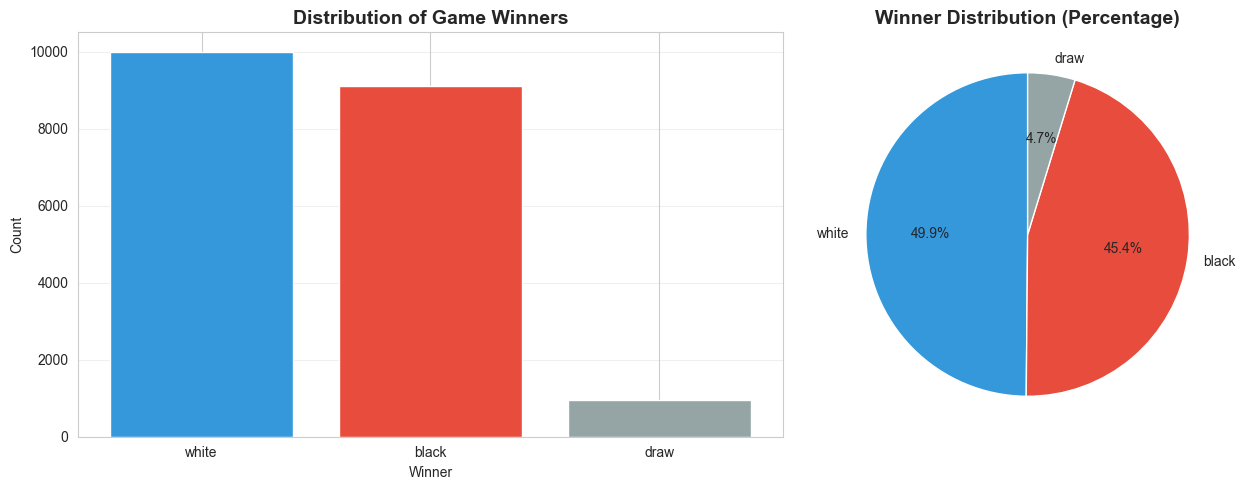


Class balance assessment:
White wins: 49.86%
Black wins: 45.40%
Draws: 4.74%


In [ ]:
# Winner distribution
print("Winner Distribution:")
print("=" * 60)
winner_counts = df['winner'].value_counts()
winner_pct = df['winner'].value_counts(normalize=True) * 100

winner_dist = pd.DataFrame({
    'Count': winner_counts,
    'Percentage': winner_pct
})
display(winner_dist)

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(winner_counts.index, winner_counts.values, color=['#3498db', '#e74c3c', '#95a5a6'])
axes[0].set_title('Distribution of Game Winners', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Winner')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

axes[1].pie(winner_counts.values, labels=winner_counts.index, autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c', '#95a5a6'], startangle=90)
axes[1].set_title('Winner Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClass balance assessment:")
print(f"White wins: {winner_pct['white']:.2f}%")
print(f"Black wins: {winner_pct['black']:.2f}%")
print(f"Draws: {winner_pct['draw']:.2f}%")


Game Length (Turns) Statistics:
count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64
[auto-save] Saved distribution_of_game_length_turns.png and distribution_of_game_length_turns.pdf


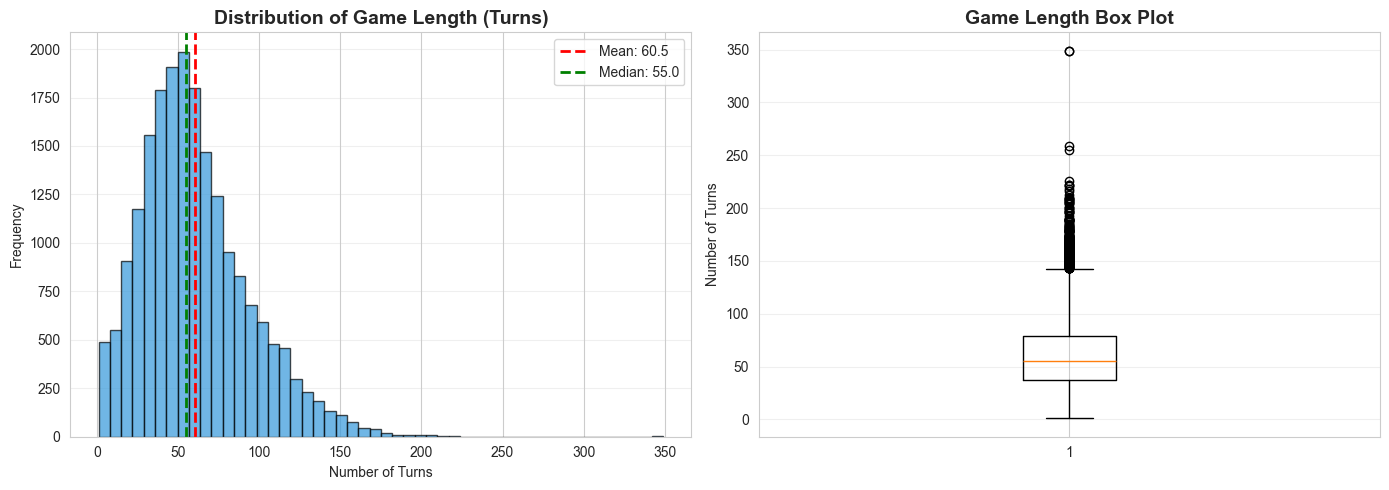

In [ ]:
# Game length distribution
print("Game Length (Turns) Statistics:")
print("=" * 60)
print(df['turns'].describe())

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['turns'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Game Length (Turns)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Turns')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['turns'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["turns"].mean():.1f}')
axes[0].axvline(df['turns'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["turns"].median():.1f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].boxplot(df['turns'], vert=True)
axes[1].set_title('Game Length Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Turns')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Victory Status Distribution:


victory_status
resign       11147
mate          6325
outoftime     1680
draw           906
Name: count, dtype: int64

[auto-save] Saved distribution_of_victory_status.png and distribution_of_victory_status.pdf


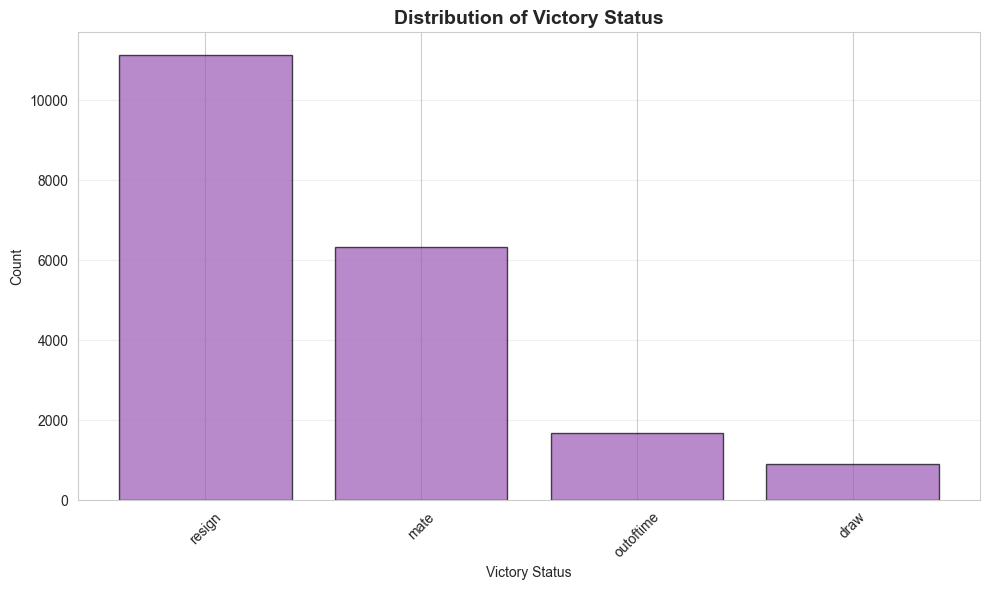

In [ ]:
# Victory status distribution
print("Victory Status Distribution:")
print("=" * 60)
victory_counts = df['victory_status'].value_counts()
display(victory_counts)

# Visualize distribution
plt.figure(figsize=(10, 6))
plt.bar(victory_counts.index, victory_counts.values, color='#9b59b6', alpha=0.7, edgecolor='black')
plt.title('Distribution of Victory Status', fontsize=14, fontweight='bold')
plt.xlabel('Victory Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 3.2 Rating Analysis


Rating Statistics:


,White Rating,Black Rating
Mean,1596.631868,1588.831987
Median,1567.000000,1562.000000
Std Dev,291.253376,291.036126


[auto-save] Saved rating_distributions.png and rating_distributions.pdf


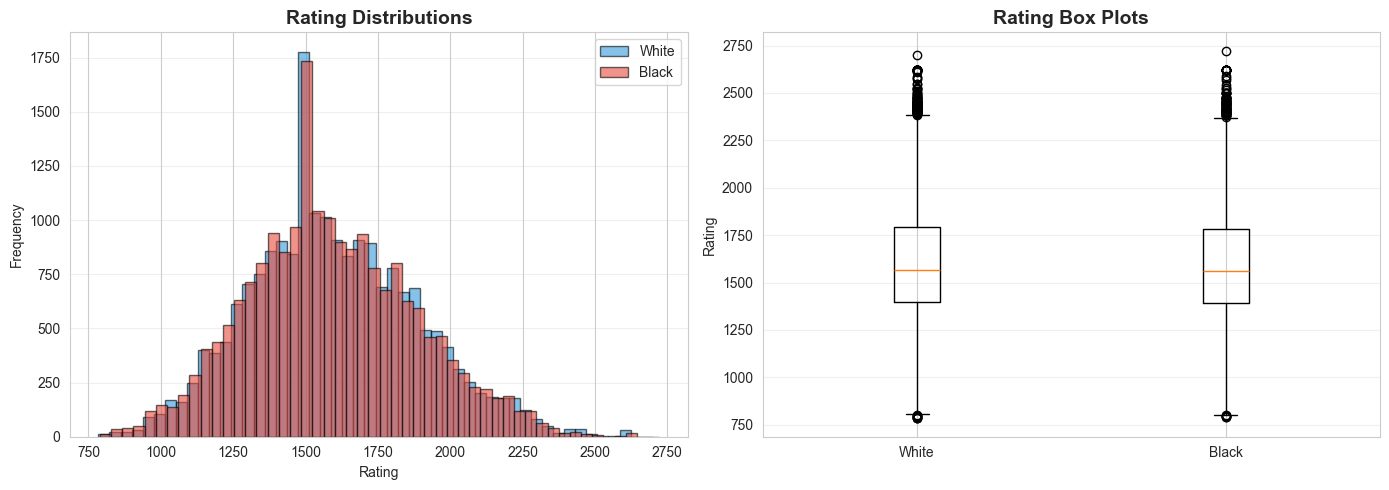

In [ ]:
# Rating distributions
print("Rating Statistics:")
print("=" * 60)
rating_stats = pd.DataFrame({
    'White Rating': [df['white_rating'].mean(), df['white_rating'].median(), df['white_rating'].std()],
    'Black Rating': [df['black_rating'].mean(), df['black_rating'].median(), df['black_rating'].std()]
}, index=['Mean', 'Median', 'Std Dev'])
display(rating_stats)

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['white_rating'], bins=50, alpha=0.6, label='White', color='#3498db', edgecolor='black')
axes[0].hist(df['black_rating'], bins=50, alpha=0.6, label='Black', color='#e74c3c', edgecolor='black')
axes[0].set_title('Rating Distributions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

box_data = [df['white_rating'], df['black_rating']]
axes[1].boxplot(box_data, labels=['White', 'Black'])
axes[1].set_title('Rating Box Plots', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Rating')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


[auto-save] Saved rating_difference_vs_winner.png and rating_difference_vs_winner.pdf


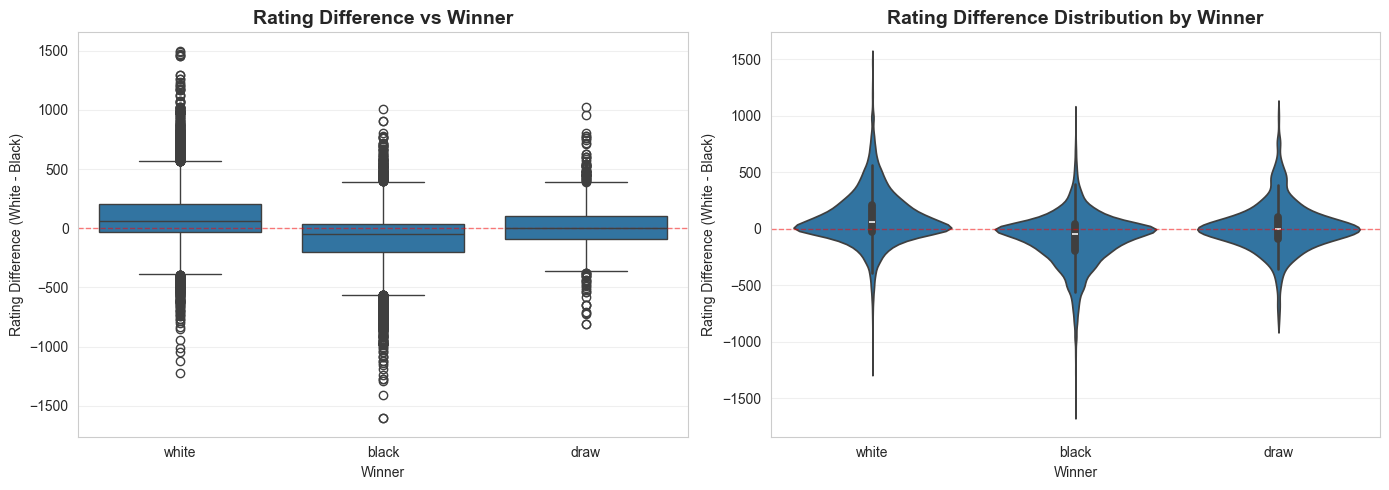

In [ ]:
# Rating difference vs winner
df_temp = df.copy()
df_temp['rating_difference'] = df_temp['white_rating'] - df_temp['black_rating']

# Visualize relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df_temp, x='winner', y='rating_difference', ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_title('Rating Difference vs Winner', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Winner')
axes[0].set_ylabel('Rating Difference (White - Black)')
axes[0].grid(axis='y', alpha=0.3)

sns.violinplot(data=df_temp, x='winner', y='rating_difference', ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_title('Rating Difference Distribution by Winner', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Winner')
axes[1].set_ylabel('Rating Difference (White - Black)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 3.3 Opening Analysis


[auto-save] Saved opening_depth_opening_ply_distribution.png and opening_depth_opening_ply_distribution.pdf


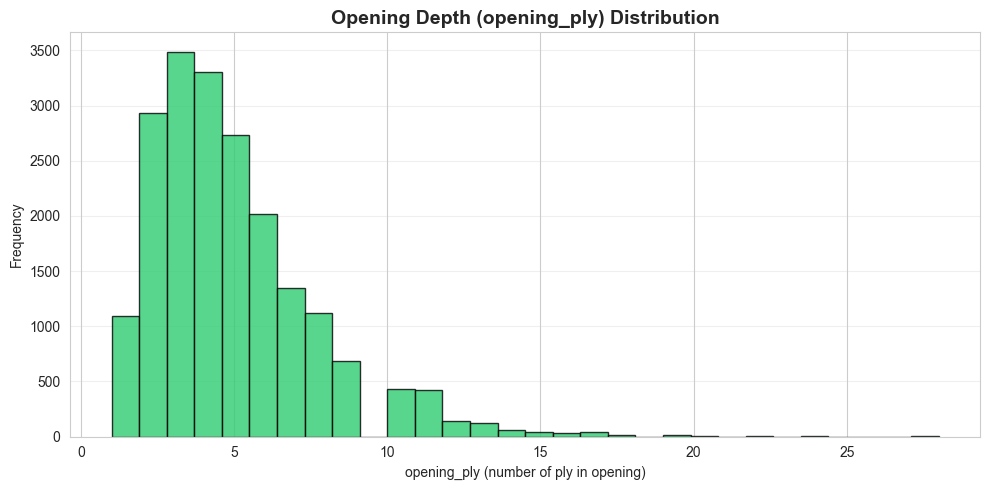

In [67]:
# Opening depth (opening_ply) distribution
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df['opening_ply'], bins=30, color='#2ecc71', edgecolor='black', alpha=0.8)
ax.set_title('Opening Depth (opening_ply) Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('opening_ply (number of ply in opening)')
ax.set_ylabel('Frequency')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Top 10 Most Common Openings:


opening_name
Van't Kruijs Opening                             368
Sicilian Defense                                 358
Sicilian Defense: Bowdler Attack                 296
Scotch Game                                      271
French Defense: Knight Variation                 271
Scandinavian Defense: Mieses-Kotroc Variation    259
Queen's Pawn Game: Mason Attack                  232
Queen's Pawn Game: Chigorin Variation            229
Scandinavian Defense                             223
Horwitz Defense                                  209
Name: count, dtype: int64

[auto-save] Saved top_10_most_common_openings.png and top_10_most_common_openings.pdf


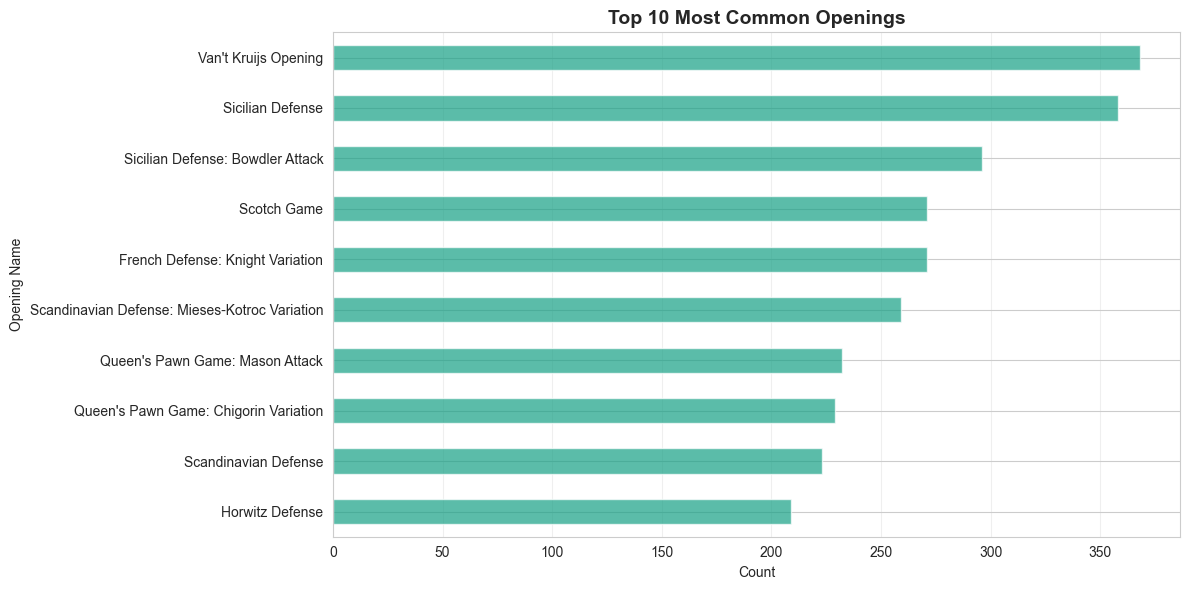

In [ ]:
# Most common openings
print("Top 10 Most Common Openings:")
print("=" * 60)
top_openings = df['opening_name'].value_counts().head(10)
display(top_openings)

# Visualize
plt.figure(figsize=(12, 6))
top_openings.plot(kind='barh', color='#16a085', alpha=0.7)
plt.title('Top 10 Most Common Openings', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Opening Name')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


Correlation Matrix - Basic Variables:
[auto-save] Saved correlation_matrix_of_numerical_variables.png and correlation_matrix_of_numerical_variables.pdf


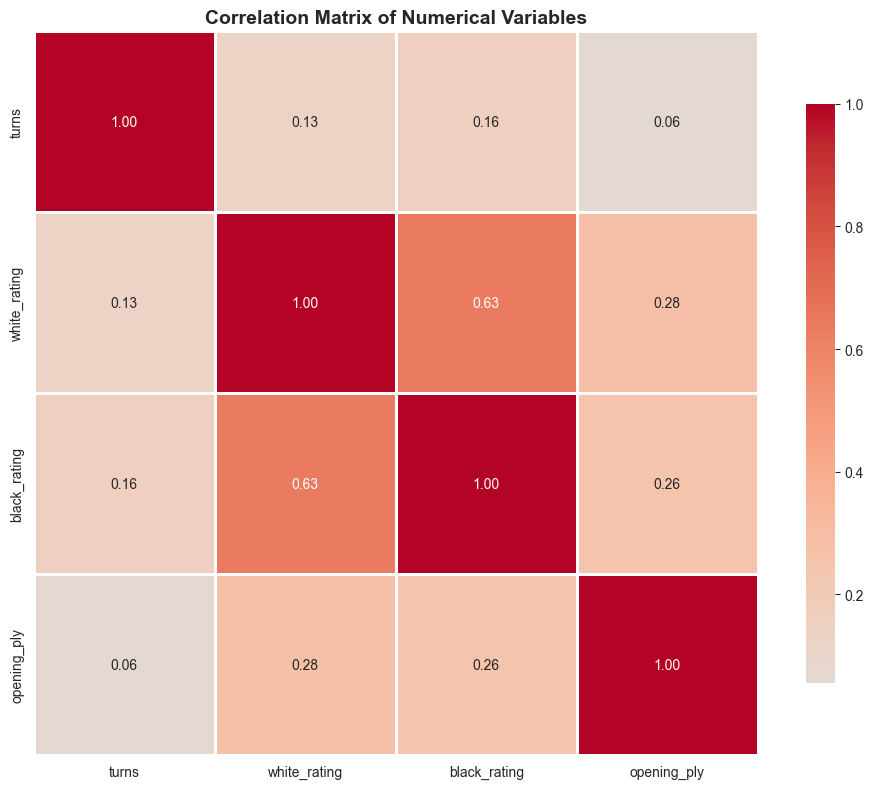

In [ ]:
# Correlation analysis
print("Correlation Matrix - Basic Variables:")
print("=" * 60)
numerical_cols = ['turns', 'white_rating', 'black_rating', 'opening_ply']
corr_matrix = df[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
## 3.4 Distribution Analysis: Skewness and Kurtosis

# Distribution characteristics
from scipy import stats

print("Distribution Characteristics (Skewness and Kurtosis):")
print("=" * 60)

dist_stats = pd.DataFrame({
    'Variable': ['turns', 'white_rating', 'black_rating', 'opening_ply'],
    'Skewness': [
        stats.skew(df['turns']),
        stats.skew(df['white_rating']),
        stats.skew(df['black_rating']),
        stats.skew(df['opening_ply'])
    ],
    'Kurtosis': [
        stats.kurtosis(df['turns']),
        stats.kurtosis(df['white_rating']),
        stats.kurtosis(df['black_rating']),
        stats.kurtosis(df['opening_ply'])
    ]
})

display(dist_stats)

print("\nNote: Turns is right-skewed; may require transformation.")


Distribution Characteristics (Skewness and Kurtosis):


,Variable,Skewness,Kurtosis
0,turns,0.897217,1.384516
1,white_rating,0.300744,0.008602
2,black_rating,0.258491,-0.072558
3,opening_ply,1.334457,3.088625



Interpretation:
- Skewness: Values close to 0 indicate normal distribution.
  Positive values indicate right skew, negative values indicate left skew.
- Kurtosis: Values close to 0 indicate normal distribution.
  Positive values indicate heavy tails, negative values indicate light tails.

Note: Turns appears to be right-skewed, which may require transformation for regression.


Victory Status Distribution:


,Count,Percentage
victory_status,,
resign,11147,55.573836
mate,6325,31.533553
outoftime,1680,8.375710
draw,906,4.516901


[auto-save] Saved distribution_of_victory_status_1.png and distribution_of_victory_status_1.pdf


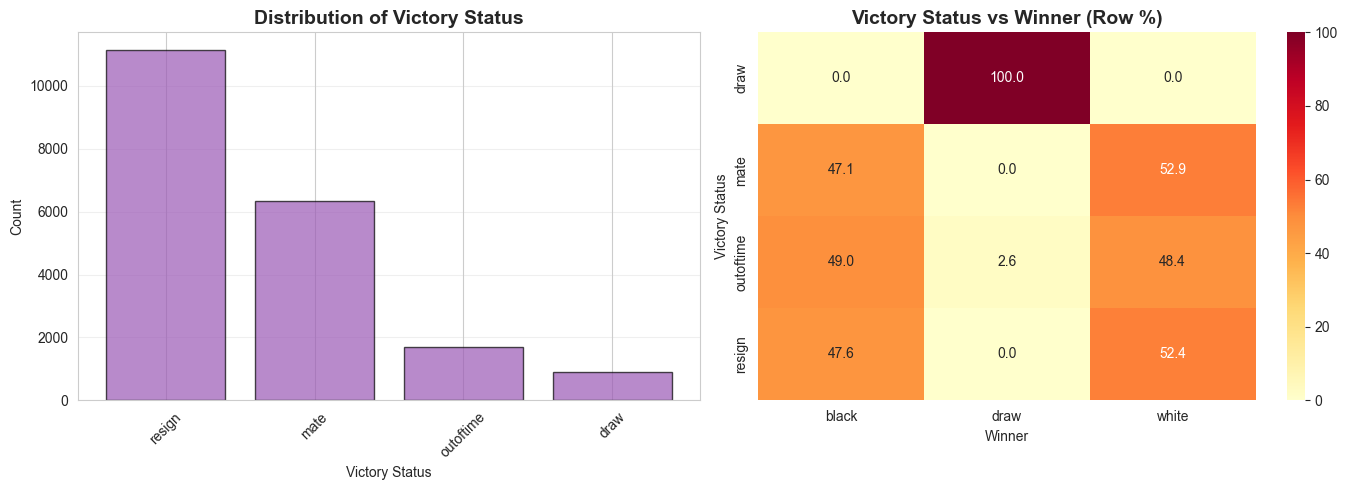


Average Game Length by Victory Status:


,mean,median,std
victory_status,,,
draw,83.781457,86.0,45.318111
mate,65.415020,59.0,33.245468
outoftime,72.742857,71.0,39.104104
resign,53.912533,50.0,29.665326


In [ ]:
## 3.5 Victory Status Analysis

# Victory status analysis
print("Victory Status Distribution:")
print("=" * 60)
victory_counts = df['victory_status'].value_counts()
victory_pct = df['victory_status'].value_counts(normalize=True) * 100

victory_dist = pd.DataFrame({
    'Count': victory_counts,
    'Percentage': victory_pct
})
display(victory_dist)

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(victory_counts.index, victory_counts.values, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Victory Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Victory Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

victory_winner = pd.crosstab(df['victory_status'], df['winner'], normalize='index') * 100
sns.heatmap(victory_winner, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Victory Status vs Winner (Row %)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Winner')
axes[1].set_ylabel('Victory Status')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Average game length by victory status
print("\nAverage Game Length by Victory Status:")
print("=" * 60)
turns_by_victory = df.groupby('victory_status')['turns'].agg(['mean', 'median', 'std'])
display(turns_by_victory)


# 4. Feature Engineering

In this section, we create new features that may be more predictive than the raw features.


In [ ]:
# Create working copy
df_clean = df.copy()

# Rating difference features
df_clean['rating_difference'] = df_clean['white_rating'] - df_clean['black_rating']
df_clean['abs_rating_difference'] = df_clean['rating_difference'].abs()
df_clean['avg_rating'] = (df_clean['white_rating'] + df_clean['black_rating']) / 2
df_clean['rating_product'] = df_clean['white_rating'] * df_clean['black_rating']

print("Rating features created:")
print(f"  - rating_difference: {df_clean['rating_difference'].describe()}")
print(f"  - abs_rating_difference: {df_clean['abs_rating_difference'].describe()}")
print(f"  - avg_rating: {df_clean['avg_rating'].describe()}")


Rating features created:
  - rating_difference: count    20058.000000
mean         7.799880
std        249.036667
min      -1605.000000
25%       -108.000000
50%          3.000000
75%        122.000000
max       1499.000000
Name: rating_difference, dtype: float64
  - abs_rating_difference: count    20058.000000
mean       173.091435
std        179.214854
min          0.000000
25%         45.000000
50%        115.000000
75%        241.000000
max       1605.000000
Name: abs_rating_difference, dtype: float64
  - avg_rating: count    20058.000000
mean      1592.731927
std        263.173825
min        816.500000
25%       1406.500000
50%       1568.750000
75%       1771.000000
max       2475.500000
Name: avg_rating, dtype: float64


In [ ]:
# Additional feature engineering

# Ensure required features exist
if 'time_control_minutes' not in df_clean.columns:
    print("Creating time control features from increment_code...")
    def parse_time_control(code):
        """Parse time control code."""
        try:
            if pd.isna(code):
                return None, None
            parts = str(code).split('+')
            minutes = int(parts[0])
            seconds = int(parts[1]) if len(parts) > 1 else 0
            return minutes, seconds
        except:
            return None, None
    
    time_controls = df_clean['increment_code'].apply(lambda x: parse_time_control(x))
    df_clean['time_control_minutes'] = time_controls.apply(lambda x: x[0] if x[0] is not None else np.nan)
    df_clean['time_control_seconds'] = time_controls.apply(lambda x: x[1] if x[1] is not None else np.nan)
    df_clean['total_time_per_player'] = df_clean['time_control_minutes'] * 60 + df_clean['time_control_seconds']
    print("Time control features created.")
else:
    print("Time control features already exist.")

if 'opening_category' not in df_clean.columns:
    print("Creating opening_category from opening_name...")
    df_clean['opening_category'] = df_clean['opening_name'].apply(
        lambda x: str(x).split(':')[0].strip() if pd.notna(x) else 'Unknown'
    )
    print(f"Opening category created. Number of unique categories: {df_clean['opening_category'].nunique()}")
else:
    print(f"Opening category already exists. Number of unique categories: {df_clean['opening_category'].nunique()}")

if 'rating_difference' not in df_clean.columns:
    print("Creating rating difference features...")
    df_clean['rating_difference'] = df_clean['white_rating'] - df_clean['black_rating']
    df_clean['abs_rating_difference'] = df_clean['rating_difference'].abs()
    df_clean['avg_rating'] = (df_clean['white_rating'] + df_clean['black_rating']) / 2
    print("Rating features created.")
else:
    print("Rating features already exist.")

# Encode victory_status
le_victory = LabelEncoder()
df_clean['victory_status_encoded'] = le_victory.fit_transform(df_clean['victory_status'])

print("\nVictory Status Encoding:")
print("=" * 60)
victory_mapping = dict(zip(le_victory.classes_, le_victory.transform(le_victory.classes_)))
for status, code in victory_mapping.items():
    print(f"{status}: {code}")

# Encode opening_category
if 'opening_category_encoded' not in df_clean.columns:
    le_opening_fe = LabelEncoder()
    df_clean['opening_category_encoded'] = le_opening_fe.fit_transform(df_clean['opening_category'].astype(str))
    print(f"\nOpening category encoded. Number of unique openings: {len(le_opening_fe.classes_)}")
else:
    print("\nOpening category already encoded.")

# Interaction features
df_clean['rating_diff_x_opening'] = df_clean['rating_difference'] * df_clean['opening_category_encoded']
df_clean['rating_diff_x_time'] = df_clean['rating_difference'] * df_clean['time_control_minutes']
df_clean['avg_rating_x_opening'] = df_clean['avg_rating'] * df_clean['opening_category_encoded']

# Opening popularity features
opening_counts = df_clean['opening_category'].value_counts()
df_clean['opening_frequency'] = df_clean['opening_category'].map(opening_counts)
df_clean['opening_rarity'] = 1 / (df_clean['opening_frequency'] + 1)

# Normalize opening frequency
df_clean['opening_frequency_norm'] = (df_clean['opening_frequency'] - opening_counts.min()) / (opening_counts.max() - opening_counts.min())

print("\nNew Interaction and Popularity Features Created:")
print("=" * 60)
new_interaction_features = ['victory_status_encoded', 'rating_diff_x_opening', 'rating_diff_x_time', 
                            'avg_rating_x_opening', 'opening_frequency', 'opening_rarity', 'opening_frequency_norm']
print(f"Total new features: {len(new_interaction_features)}")
print(f"Features: {new_interaction_features}")

# Display statistics
print("\nOpening Frequency Statistics:")
print(df_clean['opening_frequency'].describe())


Creating time control features from increment_code...
Time control features created.
Creating opening_category from opening_name...
Opening category created. Number of unique categories: 227
Rating features already exist.

Victory Status Encoding:
draw: 0
mate: 1
outoftime: 2
resign: 3

Opening category encoded. Number of unique openings: 227

New Interaction and Popularity Features Created:
Total new features: 7
Features: ['victory_status_encoded', 'rating_diff_x_opening', 'rating_diff_x_time', 'avg_rating_x_opening', 'opening_frequency', 'opening_rarity', 'opening_frequency_norm']

Opening Frequency Statistics:
count    20058.000000
mean       764.948848
std        791.277585
min          1.000000
25%        183.000000
50%        465.000000
75%        981.000000
max       2573.000000
Name: opening_frequency, dtype: float64


## 4.1 Enhanced Correlation Analysis (After Feature Engineering)

Now that we have engineered features, let's analyze correlations with all features.


Enhanced Correlation Analysis (All Features):
[auto-save] Saved enhanced_correlation_matrix_all_numerical_features.png and enhanced_correlation_matrix_all_numerical_features.pdf


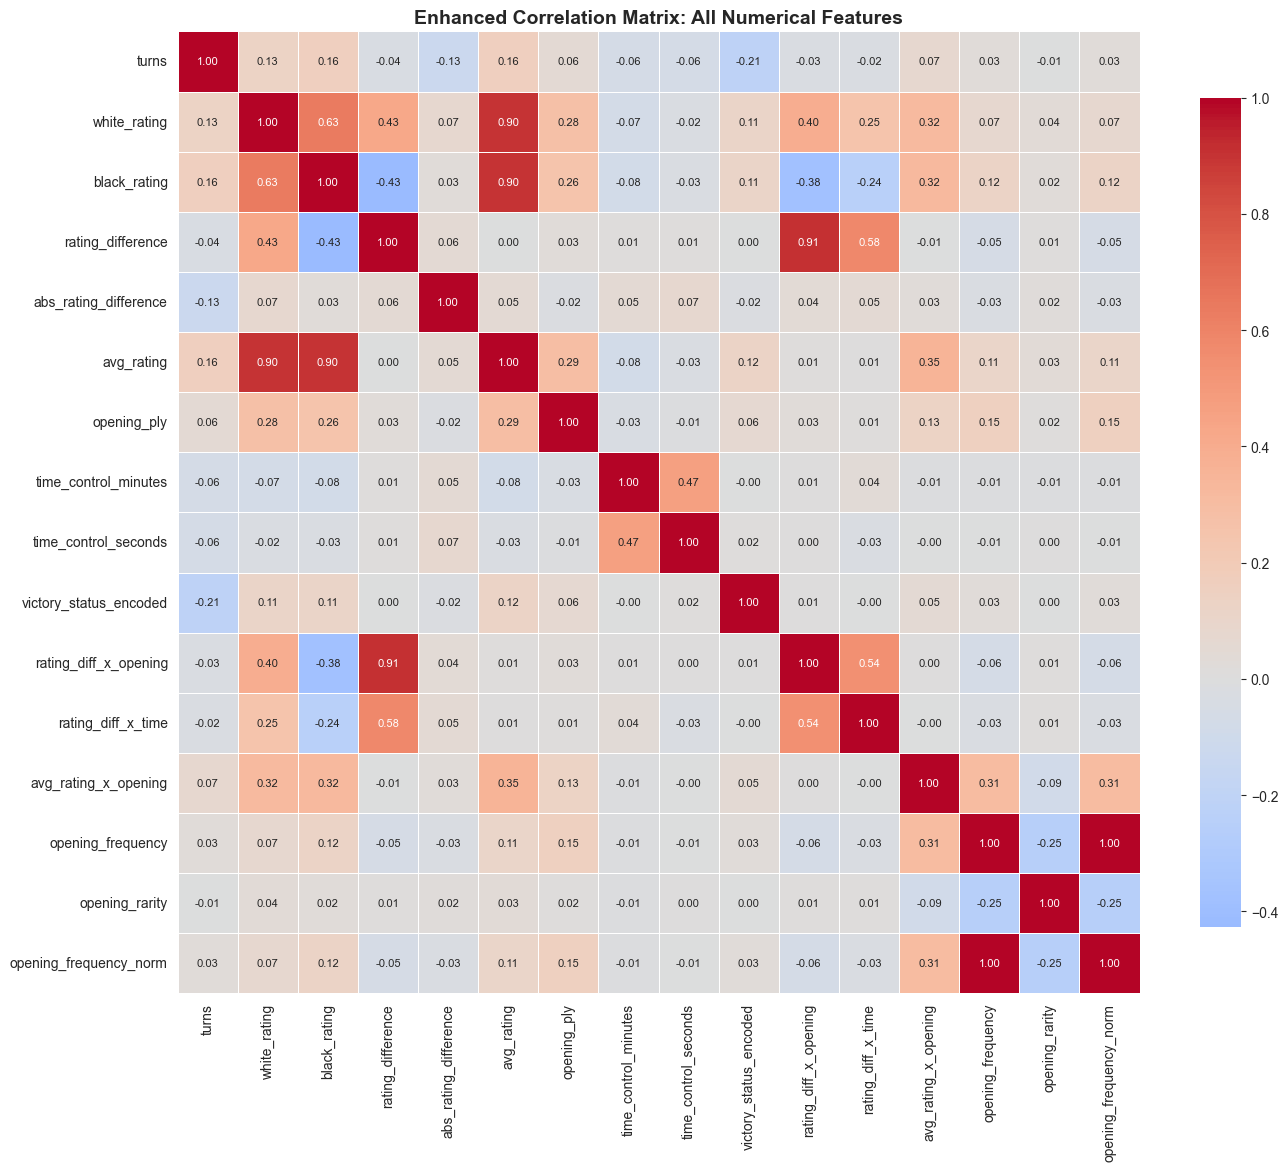


Highly Correlated Feature Pairs (|r| > 0.7):


,Feature 1,Feature 2,Correlation
3,opening_frequency,opening_frequency_norm,1.000000
2,rating_difference,rating_diff_x_opening,0.910262
0,white_rating,avg_rating,0.904003
1,black_rating,avg_rating,0.903852



Note: High correlations may indicate multicollinearity. Consider removing redundant features.

Correlation with Target Variables:

Correlation with winner:


rating_difference         0.360669
rating_diff_x_opening     0.326083
rating_diff_x_time        0.197628
black_rating             -0.166815
white_rating              0.141700
turns                    -0.044346
opening_frequency        -0.035692
opening_frequency_norm   -0.035692
opening_ply               0.020669
opening_rarity            0.014686
Name: correlation, dtype: float64


Correlation with turns:


victory_status_encoded    0.160526
rating_diff_x_opening     0.160526
rating_difference         0.160467
abs_rating_difference     0.160467
black_rating              0.129753
white_rating              0.129753
time_control_minutes     -0.126531
time_control_seconds     -0.126531
opening_frequency_norm   -0.060036
opening_frequency        -0.059298
Name: correlation, dtype: float64

In [ ]:
# Enhanced correlation analysis
print("Enhanced Correlation Analysis (All Features):")
print("=" * 60)

numerical_features_all = ['turns', 'white_rating', 'black_rating', 'rating_difference',
                          'abs_rating_difference', 'avg_rating', 'opening_ply',
                          'time_control_minutes', 'time_control_seconds', 'is_rated',
                          'opening_cluster', 'victory_status_encoded',
                          'rating_diff_x_opening', 'rating_diff_x_time', 'avg_rating_x_opening',
                          'opening_frequency', 'opening_rarity', 'opening_frequency_norm']

numerical_features_all = [f for f in numerical_features_all if f in df_clean.columns]

corr_matrix_all = df_clean[numerical_features_all].corr()

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_all, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={'size': 8})
plt.title('Enhanced Correlation Matrix: All Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated features
print("\nHighly Correlated Feature Pairs (|r| > 0.7):")
print("=" * 60)
high_corr_pairs = []
for i in range(len(corr_matrix_all.columns)):
    for j in range(i+1, len(corr_matrix_all.columns)):
        corr_val = corr_matrix_all.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((corr_matrix_all.columns[i], corr_matrix_all.columns[j], corr_val))

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
    high_corr_df['abs_correlation'] = high_corr_df['Correlation'].abs()
    high_corr_df = high_corr_df.sort_values('abs_correlation', ascending=False).drop('abs_correlation', axis=1)
    display(high_corr_df)
    print("\nNote: High correlations may indicate multicollinearity.")
else:
    print("No highly correlated pairs found (|r| > 0.7).")

# Correlation with target variables
print("\nCorrelation with Target Variables:")
print("=" * 60)
targets = ['winner', 'turns']
for target in targets:
    if target in df_clean.columns:
        if target == 'winner':
            df_temp = df_clean.copy()
            df_temp['winner_encoded'] = LabelEncoder().fit_transform(df_temp['winner'])
            corr_matrix = df_temp[numerical_features_all + ['winner_encoded']].corr()
            corr_series = corr_matrix['winner_encoded']
            corr_with_target = corr_series.drop('winner_encoded')
        else:
            corr_matrix = df_clean[numerical_features_all + [target]].corr()
            corr_series = corr_matrix[target]
            corr_with_target = corr_series.drop(target)
        
        if not isinstance(corr_with_target, pd.Series):
            if isinstance(corr_with_target, pd.DataFrame):
                corr_with_target = corr_with_target.iloc[:, 0] if corr_with_target.shape[1] == 1 else corr_with_target.squeeze()
            elif isinstance(corr_with_target, np.ndarray):
                if corr_with_target.ndim > 1:
                    corr_with_target = corr_with_target.flatten()
                corr_with_target = pd.Series(corr_with_target)
        
        corr_values = corr_with_target.values
        if corr_values.ndim > 1:
            corr_values = corr_values.flatten()
        if len(corr_values) != len(corr_with_target.index):
            corr_values = corr_values[:len(corr_with_target.index)]
        
        temp_df = pd.DataFrame({
            'correlation': corr_values,
            'abs_correlation': np.abs(corr_values)
        }, index=corr_with_target.index)
        temp_df = temp_df.sort_values('abs_correlation', ascending=False)
        corr_with_target_sorted = temp_df['correlation']
        
        print(f"\nCorrelation with {target}:")
        display(corr_with_target_sorted.head(10))


In [ ]:
# Time control features already created
print("Time control features already created earlier. Skipping this cell.")


Time control features already created earlier. Skipping this cell.


In [ ]:
# Game length categories
df_clean['game_length_category'] = pd.cut(df_clean['turns'], 
                                           bins=[0, 30, 60, 90, float('inf')],
                                           labels=['Short', 'Medium', 'Long', 'Very Long'])

# Opening category
df_clean['opening_category'] = df_clean['opening_name'].apply(
    lambda x: str(x).split(':')[0].strip() if pd.notna(x) else 'Unknown'
)

print("Categorical features created:")
print(f"  - Game length categories: {df_clean['game_length_category'].value_counts()}")
print(f"\n  - Top opening categories: {df_clean['opening_category'].value_counts().head(10)}")


Categorical features created:
  - Game length categories: game_length_category
Medium       7839
Long         5160
Short        3566
Very Long    3493
Name: count, dtype: int64

  - Top opening categories: opening_category
Sicilian Defense        2573
French Defense          1306
Queen's Pawn Game       1059
Italian Game             981
King's Pawn Game         917
Ruy Lopez                858
English Opening          720
Scandinavian Defense     716
Caro-Kann Defense        593
Scotch Game              465
Name: count, dtype: int64


In [ ]:
# Binary features
df_clean['is_rated'] = df_clean['rated'].astype(int)

# Feature engineering summary
print("Feature Engineering Summary:")
print("=" * 60)
print(f"Original features: {len(df.columns)}")
print(f"New features created: {len(df_clean.columns) - len(df.columns)}")
print(f"Total features: {len(df_clean.columns)}")
print("\nNew features:")
new_features = [col for col in df_clean.columns if col not in df.columns]
print(new_features)

display(df_clean[['winner', 'turns', 'rating_difference', 'abs_rating_difference', 
                   'avg_rating', 'time_control_minutes', 'opening_category']].head())


Feature Engineering Summary:
Original features: 16
New features created: 18
Total features: 34

New features:
['rating_difference', 'abs_rating_difference', 'avg_rating', 'rating_product', 'time_control_minutes', 'time_control_seconds', 'total_time_per_player', 'opening_category', 'victory_status_encoded', 'opening_category_encoded', 'rating_diff_x_opening', 'rating_diff_x_time', 'avg_rating_x_opening', 'opening_frequency', 'opening_rarity', 'opening_frequency_norm', 'game_length_category', 'is_rated']


,winner,turns,rating_difference,abs_rating_difference,avg_rating,time_control_minutes,opening_category
0,white,13,309,309,1345.5,15,Slav Defense
1,black,16,61,61,1291.5,5,Nimzowitsch Defense
2,white,61,-4,4,1498.0,5,King's Pawn Game
3,white,61,-15,15,1446.5,20,Queen's Pawn Game
4,white,95,54,54,1496.0,30,Philidor Defense


# 5. Unsupervised Learning: Clustering & Dimension Reduction

## 5.1 Principal Component Analysis (PCA)

PCA is used to reduce dimensionality and visualize the feature space.


In [ ]:
# Prepare features for PCA
pca_features = ['white_rating', 'black_rating', 'rating_difference', 
                'abs_rating_difference', 'avg_rating', 'turns', 
                'time_control_minutes', 'time_control_seconds']

df_pca = df_clean[pca_features].dropna()

print(f"Data for PCA: {df_pca.shape}")
print(f"Missing values removed: {len(df_clean) - len(df_pca)}")

# Standardize features
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(df_pca)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_pca_scaled)

print("\nPCA fitted successfully!")


Data for PCA: (20058, 8)
Missing values removed: 0

PCA fitted successfully!


## 5.2 Clustering Openings

We cluster openings based on their characteristics to identify patterns. This analysis includes:
- Enhanced feature engineering (game length variability, draw rates, rating differences)
- Comprehensive evaluation of multiple cluster numbers (2-8) using multiple metrics
- Comparison of K-Means and Hierarchical clustering methods
- Statistical validation of clusters against game outcomes
- Enhanced visualizations (PCA, t-SNE, dendrograms)


In [ ]:
# Mapping step moved later
print("Skipping: mapping of improved clusters is performed after clustering cells.")


Skipping: mapping of improved clusters is performed after clustering cells.


Explained Variance by Component:
PC1: 0.3367 (33.67%) | Cumulative: 0.3367 (33.67%)
PC2: 0.1875 (18.75%) | Cumulative: 0.5241 (52.41%)
PC3: 0.1715 (17.15%) | Cumulative: 0.6957 (69.57%)
PC4: 0.1334 (13.34%) | Cumulative: 0.8290 (82.90%)
PC5: 0.1047 (10.47%) | Cumulative: 0.9338 (93.38%)
PC6: 0.0662 (6.62%) | Cumulative: 1.0000 (100.00%)
PC7: 0.0000 (0.00%) | Cumulative: 1.0000 (100.00%)
PC8: 0.0000 (0.00%) | Cumulative: 1.0000 (100.00%)
[auto-save] Saved scree_plot_explained_variance_by_component.png and scree_plot_explained_variance_by_component.pdf


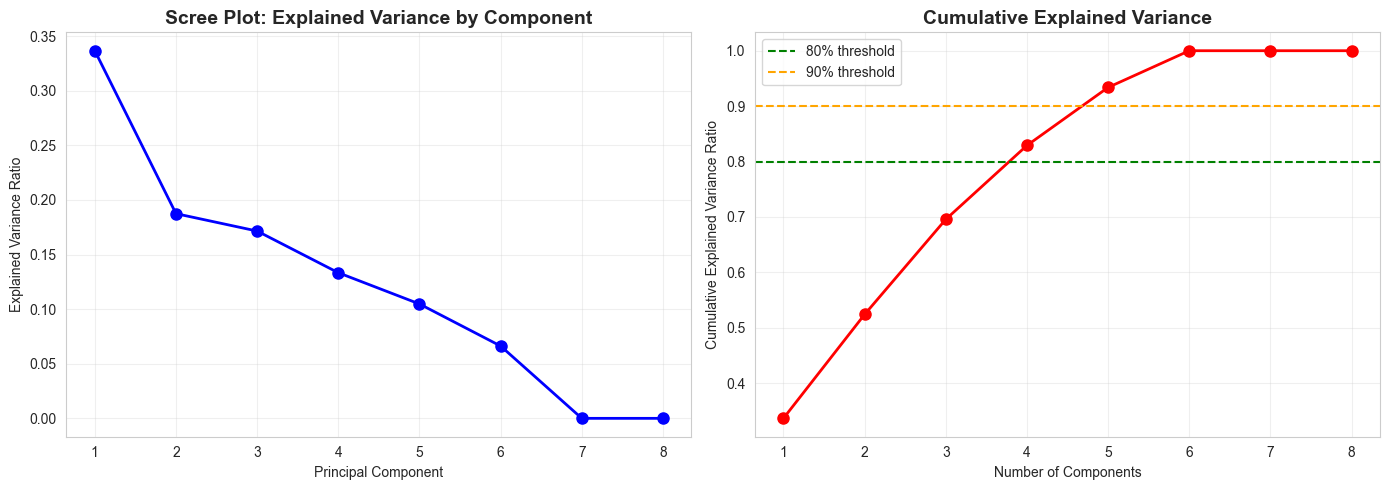


Components needed for 80% variance: 4
Components needed for 90% variance: 5


In [ ]:
# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("Explained Variance by Component:")
print("=" * 60)
for i, (var, cum_var) in enumerate(zip(explained_var, cumulative_var), 1):
    print(f"PC{i}: {var:.4f} ({var*100:.2f}%) | Cumulative: {cum_var:.4f} ({cum_var*100:.2f}%)")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, len(explained_var) + 1), explained_var, 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Scree Plot: Explained Variance by Component', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=0.8, color='green', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance Ratio')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find components for 80% and 90% variance
n_components_80 = np.where(cumulative_var >= 0.8)[0][0] + 1
n_components_90 = np.where(cumulative_var >= 0.9)[0][0] + 1
print(f"\nComponents needed for 80% variance: {n_components_80}")
print(f"Components needed for 90% variance: {n_components_90}")


Component Loadings (First 3 Principal Components):


,PC1,PC2,PC3
white_rating,0.545131,0.166756,0.328193
black_rating,0.547871,-0.035726,-0.354881
rating_difference,-0.002727,0.236776,0.798559
abs_rating_difference,0.034046,0.266285,0.105658
avg_rating,0.604585,0.072520,-0.014621
turns,0.153832,-0.180844,-0.082214
time_control_minutes,-0.096337,0.626537,-0.234907
time_control_seconds,-0.055083,0.642988,-0.235232


[auto-save] Saved component_loadings_for_first_3_principal_components.png and component_loadings_for_first_3_principal_components.pdf


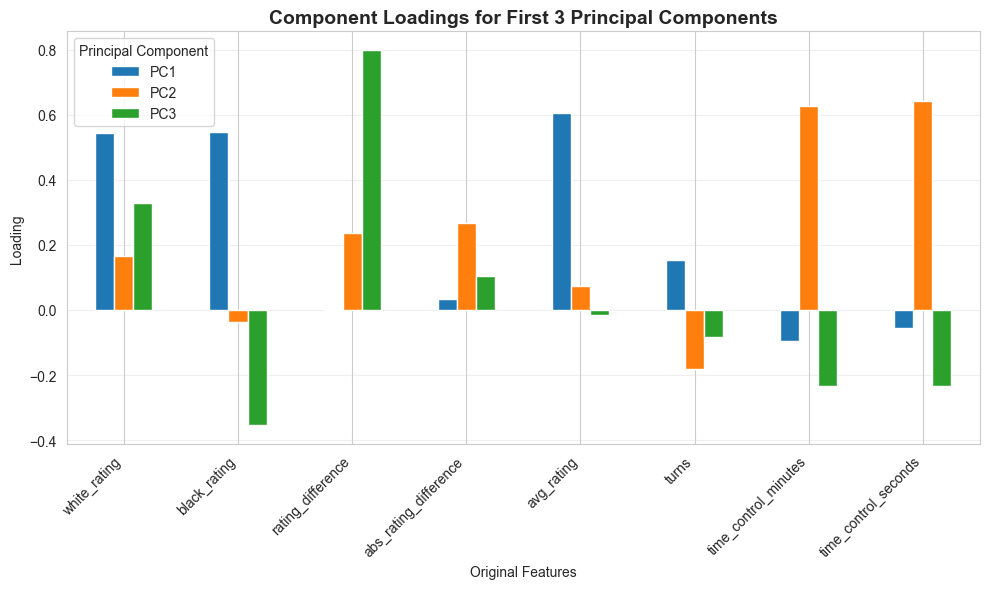

In [ ]:
# Component loadings
print("Component Loadings (First 3 Principal Components):")
print("=" * 60)
loadings_df = pd.DataFrame(
    pca.components_[:3].T,
    columns=[f'PC{i+1}' for i in range(3)],
    index=pca_features
)
display(loadings_df)

# Visualize loadings
fig, ax = plt.subplots(figsize=(10, 6))
loadings_df.plot(kind='bar', ax=ax)
ax.set_title('Component Loadings for First 3 Principal Components', fontsize=14, fontweight='bold')
ax.set_xlabel('Original Features')
ax.set_ylabel('Loading')
ax.legend(title='Principal Component')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 5.2.1 Feature Engineering for Clustering


### 5.2.2 Cluster Number Selection


### 5.2.3 K-Means Clustering


In [26]:
# IMPROVED: Enhanced Feature Engineering for Clustering
# Add more informative features for clustering

# Create opening statistics with additional features
opening_stats_improved = df_clean.groupby('opening_category').agg({
    'turns': ['mean', 'std'],  # Average and variability in game length
    'white_rating': 'mean',
    'black_rating': 'mean',
    'winner': [
        lambda x: (x == 'white').sum() / len(x),  # White win rate
        lambda x: (x == 'draw').sum() / len(x)     # Draw rate
    ],
    'rated': 'mean',
    'rating_difference': 'mean'  # Average rating difference
}).reset_index()

# Flatten column names
opening_stats_improved.columns = ['opening_category', 'avg_turns', 'std_turns',
                                  'avg_white_rating', 'avg_black_rating', 
                                  'white_win_rate', 'draw_rate', 'rated_rate',
                                  'avg_rating_diff']

# Calculate additional features
opening_stats_improved['avg_rating'] = (opening_stats_improved['avg_white_rating'] + 
                                        opening_stats_improved['avg_black_rating']) / 2
opening_stats_improved['black_win_rate'] = 1 - opening_stats_improved['white_win_rate'] - opening_stats_improved['draw_rate']

# Filter openings with sufficient games (at least 10 games)
opening_counts = df_clean['opening_category'].value_counts()
significant_openings = opening_counts[opening_counts >= 10].index
opening_stats_improved = opening_stats_improved[opening_stats_improved['opening_category'].isin(significant_openings)]

print(f"Openings with at least 10 games: {len(opening_stats_improved)}")
print(f"\nEnhanced opening statistics:")
display(opening_stats_improved.head(10))


Openings with at least 10 games: 128

Enhanced opening statistics:


,opening_category,avg_turns,std_turns,avg_white_rating,avg_black_rating,white_win_rate,draw_rate,rated_rate,avg_rating_diff,avg_rating,black_win_rate
0,Alekhine Defense,58.558511,32.016904,1507.031915,1467.042553,0.542553,0.047872,0.808511,39.989362,1487.037234,0.409574
3,Amar Opening,45.071429,23.103327,1528.214286,1755.857143,0.571429,0.000000,0.571429,-227.642857,1642.035714,0.428571
5,Anderssen Opening,43.115385,25.509727,1616.538462,1553.923077,0.653846,0.038462,0.769231,62.615385,1585.230769,0.307692
7,Barnes Defense,43.562500,36.368427,1510.375000,1338.562500,0.687500,0.062500,0.937500,171.812500,1424.468750,0.250000
18,Benoni Defense,60.692308,32.192256,1764.184615,1768.061538,0.400000,0.123077,0.907692,-3.876923,1766.123077,0.476923
19,Bird Opening,55.114650,37.017662,1584.050955,1612.942675,0.382166,0.095541,0.821656,-28.891720,1598.496815,0.522293
20,Bishop's Opening,55.433437,33.403580,1530.684211,1497.569659,0.575851,0.052632,0.804954,33.114551,1514.126935,0.371517
21,Blackmar-Diemer Gambit,55.370370,29.856447,1478.870370,1491.481481,0.518519,0.000000,0.833333,-12.611111,1485.175926,0.481481
26,Blumenfeld Countergambit #2,64.400000,41.929041,1943.800000,1930.700000,0.500000,0.000000,0.800000,13.100000,1937.250000,0.500000
28,Bogo-Indian Defense,74.400000,31.091978,1965.300000,1869.600000,0.400000,0.100000,0.900000,95.700000,1917.450000,0.500000


### 5.2.4 Hierarchical Clustering Comparison


Evaluating K-Means for k = 2 to 8:
k=2: Silhouette=0.2575, Davies-Bouldin=1.3879
k=3: Silhouette=0.2305, Davies-Bouldin=1.3829
k=4: Silhouette=0.1957, Davies-Bouldin=1.4471
k=5: Silhouette=0.1948, Davies-Bouldin=1.4434
k=6: Silhouette=0.1594, Davies-Bouldin=1.4553
k=7: Silhouette=0.1743, Davies-Bouldin=1.4821
k=8: Silhouette=0.1665, Davies-Bouldin=1.4604

Best k (Silhouette): 2 (score: 0.2575)
Best k (Davies-Bouldin): 3 (score: 1.3829)
[auto-save] Saved silhouette_score_vs_number_of_clusters.png and silhouette_score_vs_number_of_clusters.pdf


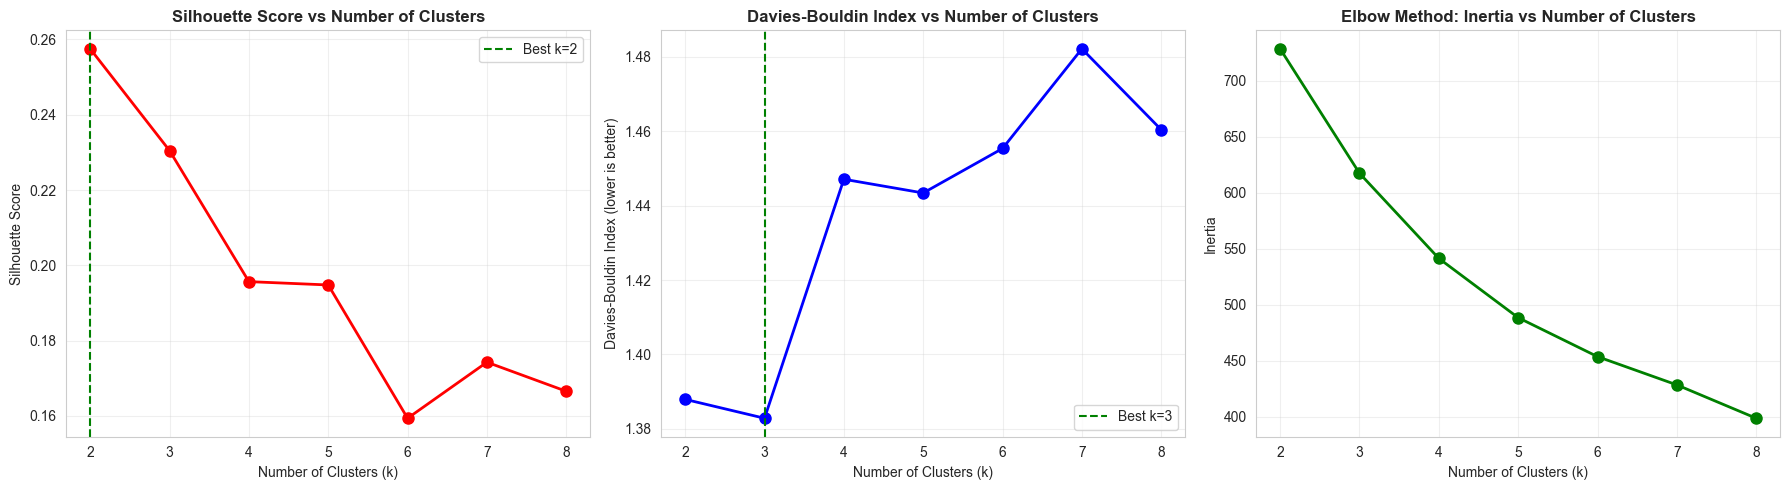


Selected optimal k: 3


In [27]:
# IMPROVED: Comprehensive Cluster Evaluation
# Test multiple cluster numbers and compare methods

# Enhanced cluster features (removed rated_rate, added more informative features)
cluster_features_improved = ['avg_turns', 'std_turns', 'avg_white_rating', 'avg_black_rating', 
                             'white_win_rate', 'draw_rate', 'avg_rating_diff', 'avg_rating']
X_cluster_improved = opening_stats_improved[cluster_features_improved].values

# Standardize
scaler_cluster_improved = StandardScaler()
X_cluster_scaled_improved = scaler_cluster_improved.fit_transform(X_cluster_improved)

# Test multiple cluster numbers (2-8)
K_range_improved = range(2, 9)
inertias_improved = []
silhouette_scores_improved = []
davies_bouldin_scores = []

print("Evaluating K-Means for k = 2 to 8:")
print("=" * 60)

for k in K_range_improved:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_cluster_scaled_improved)
    inertias_improved.append(kmeans_temp.inertia_)
    silhouette_scores_improved.append(silhouette_score(X_cluster_scaled_improved, labels_temp))
    
    # Davies-Bouldin Index (lower is better)
    from sklearn.metrics import davies_bouldin_score
    davies_bouldin_scores.append(davies_bouldin_score(X_cluster_scaled_improved, labels_temp))
    
    print(f"k={k}: Silhouette={silhouette_scores_improved[-1]:.4f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.4f}")

# Find best k based on silhouette score
best_k_silhouette = K_range_improved[np.argmax(silhouette_scores_improved)]
best_k_db = K_range_improved[np.argmin(davies_bouldin_scores)]

print(f"\nBest k (Silhouette): {best_k_silhouette} (score: {max(silhouette_scores_improved):.4f})")
print(f"Best k (Davies-Bouldin): {best_k_db} (score: {min(davies_bouldin_scores):.4f})")

# Visualize evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette scores
axes[0].plot(K_range_improved, silhouette_scores_improved, 'ro-', linewidth=2, markersize=8)
axes[0].axvline(best_k_silhouette, color='green', linestyle='--', label=f'Best k={best_k_silhouette}')
axes[0].set_title('Silhouette Score vs Number of Clusters', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Davies-Bouldin scores
axes[1].plot(K_range_improved, davies_bouldin_scores, 'bo-', linewidth=2, markersize=8)
axes[1].axvline(best_k_db, color='green', linestyle='--', label=f'Best k={best_k_db}')
axes[1].set_title('Davies-Bouldin Index vs Number of Clusters', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Index (lower is better)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Elbow method
axes[2].plot(K_range_improved, inertias_improved, 'go-', linewidth=2, markersize=8)
axes[2].set_title('Elbow Method: Inertia vs Number of Clusters', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Inertia')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose optimal k (prefer silhouette score, but consider interpretability)
optimal_k_improved = best_k_silhouette
if optimal_k_improved < 3:
    optimal_k_improved = 3  # Minimum 3 clusters for meaningful interpretation
print(f"\nSelected optimal k: {optimal_k_improved}")


### 5.2.5 Cluster Visualization


In [28]:
# IMPROVED: K-Means Clustering with Optimal k
kmeans_improved = KMeans(n_clusters=optimal_k_improved, random_state=42, n_init=10)
cluster_labels_improved = kmeans_improved.fit_predict(X_cluster_scaled_improved)

opening_stats_improved['cluster'] = cluster_labels_improved

# Detailed cluster analysis
print("IMPROVED Cluster Characteristics:")
print("=" * 60)
cluster_analysis_improved = opening_stats_improved.groupby('cluster')[cluster_features_improved].agg(['mean', 'std'])
display(cluster_analysis_improved)

# Count openings per cluster
print("\nOpenings per Cluster:")
cluster_counts = opening_stats_improved['cluster'].value_counts().sort_index()
display(cluster_counts)

# Interpret clusters
print("\nCluster Interpretation:")
print("=" * 60)
for cluster_id in sorted(opening_stats_improved['cluster'].unique()):
    cluster_data = opening_stats_improved[opening_stats_improved['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_data)} openings):")
    print(f"  - Avg game length: {cluster_data['avg_turns'].mean():.1f} turns (±{cluster_data['std_turns'].mean():.1f})")
    print(f"  - Avg rating: {cluster_data['avg_rating'].mean():.0f}")
    print(f"  - White win rate: {cluster_data['white_win_rate'].mean():.2%}")
    print(f"  - Draw rate: {cluster_data['draw_rate'].mean():.2%}")
    print(f"  - Top openings: {', '.join(cluster_data['opening_category'].head(5).tolist())}")


IMPROVED Cluster Characteristics:


avg_turns             std_turns           avg_white_rating  \
              mean        std       mean       std             mean   
cluster                                                               
0        46.611723  11.119221  27.210529  4.874945      1577.632837   
1        65.180022   6.288802  32.849235  5.679956      1716.346866   
2        58.821202   6.544289  33.201434  5.320133      1519.778144   

                    avg_black_rating            white_win_rate            \
                std             mean        std           mean       std   
cluster                                                                    
0        110.725342      1448.392955  93.820181       0.689601  0.125621   
1         94.000033      1728.841969  94.163260       0.460725  0.099676   
2         83.208947      1517.385209  69.256221       0.496670  0.107143   

        draw_rate           avg_rating_diff              avg_rating             
             mean       std            mean        std         mean        std  
cluster                                                                         
0        0.011780  0.019676      129.239882  69.954183  1513.012896  96.476769  
1        0.068277  0.041773      -12.495103  63.373362  1722.594418  88.585084  
2        0.036523  0.029012        2.392935  68.883977  1518.581677  68.365386


Openings per Cluster:


cluster
0    18
1    42
2    68
Name: count, dtype: int64


Cluster Interpretation:

Cluster 0 (18 openings):
  - Avg game length: 46.6 turns (±27.2)
  - Avg rating: 1513
  - White win rate: 68.96%
  - Draw rate: 1.18%
  - Top openings: Anderssen Opening, Barnes Defense, Borg Defense, Center Game #2, Danish Gambit Accepted

Cluster 1 (42 openings):
  - Avg game length: 65.2 turns (±32.8)
  - Avg rating: 1723
  - White win rate: 46.07%
  - Draw rate: 6.83%
  - Top openings: Benoni Defense, Blumenfeld Countergambit #2, Bogo-Indian Defense, Budapest Defense, Caro-Kann Defense

Cluster 2 (68 openings):
  - Avg game length: 58.8 turns (±33.2)
  - Avg rating: 1519
  - White win rate: 49.67%
  - Draw rate: 3.65%
  - Top openings: Alekhine Defense, Amar Opening, Bird Opening, Bishop's Opening, Blackmar-Diemer Gambit


### 5.2.6 Cluster Validation


Hierarchical Clustering Analysis:
[auto-save] Saved hierarchical_clustering_dendrogram_ward_linkage.png and hierarchical_clustering_dendrogram_ward_linkage.pdf


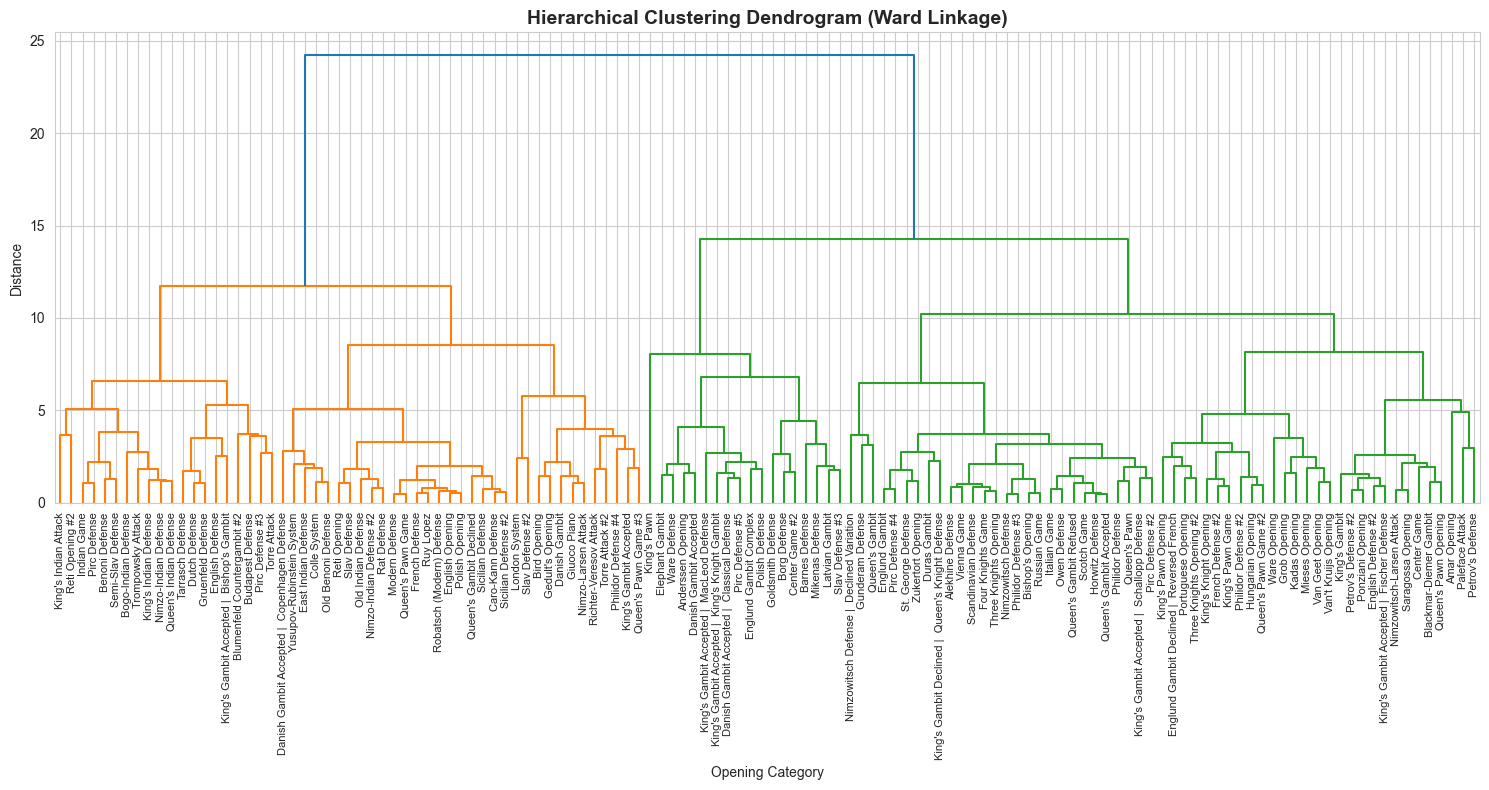


Agreement between K-Means and Hierarchical clustering: 44.53%

Openings with different cluster assignments (71):


,opening_category,kmeans_cluster,hierarchical_cluster
5,Anderssen Opening,0,1
7,Barnes Defense,0,1
18,Benoni Defense,1,0
19,Bird Opening,2,0
26,Blumenfeld Countergambit #2,1,0
28,Bogo-Indian Defense,1,0
29,Borg Defense,0,1
30,Budapest Defense,1,0
32,Caro-Kann Defense,1,0
37,Center Game #2,0,1


In [29]:
# IMPROVED: Hierarchical Clustering Comparison
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

print("Hierarchical Clustering Analysis:")
print("=" * 60)

# Perform hierarchical clustering
linkage_matrix = linkage(X_cluster_scaled_improved, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, 
           labels=opening_stats_improved['opening_category'].values,
           leaf_rotation=90,
           leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Opening Category')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Cut dendrogram at optimal_k_improved clusters
from scipy.cluster.hierarchy import fcluster
hierarchical_labels = fcluster(linkage_matrix, optimal_k_improved, criterion='maxclust') - 1  # Convert to 0-indexed

# Compare K-Means and Hierarchical clustering
comparison_df = pd.DataFrame({
    'opening_category': opening_stats_improved['opening_category'],
    'kmeans_cluster': cluster_labels_improved,
    'hierarchical_cluster': hierarchical_labels
})

# Calculate agreement
agreement = (comparison_df['kmeans_cluster'] == comparison_df['hierarchical_cluster']).mean()
print(f"\nAgreement between K-Means and Hierarchical clustering: {agreement:.2%}")

# Show disagreements
disagreements = comparison_df[comparison_df['kmeans_cluster'] != comparison_df['hierarchical_cluster']]
if len(disagreements) > 0:
    print(f"\nOpenings with different cluster assignments ({len(disagreements)}):")
    display(disagreements.head(10))


[auto-save] Saved kmeans_clusters_pca_visualization.png and kmeans_clusters_pca_visualization.pdf


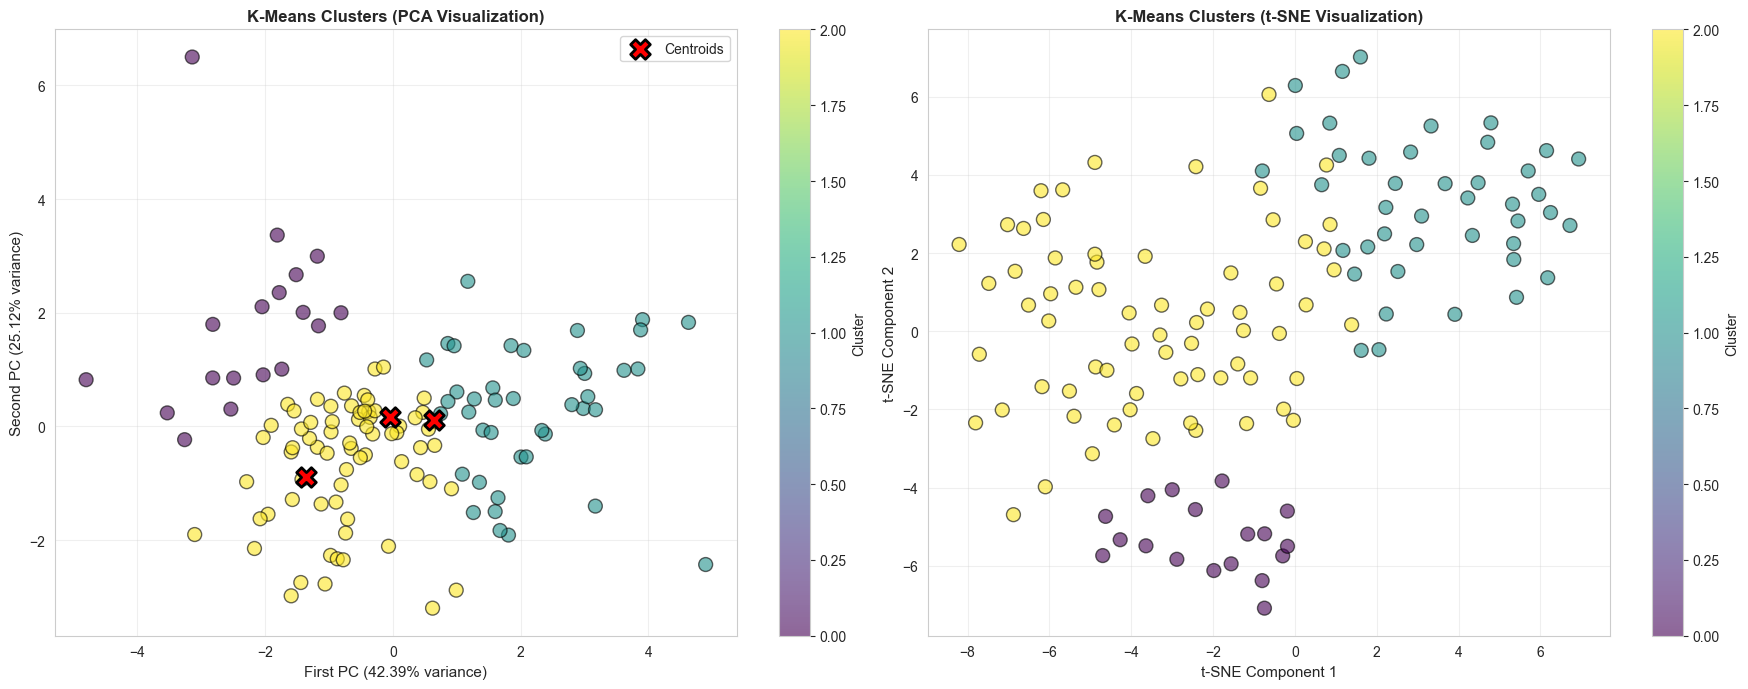


Cluster Characteristics Comparison (Normalized):


,avg_turns,std_turns,avg_white_rating,avg_black_rating,white_win_rate,draw_rate,avg_rating_diff,avg_rating
cluster,,,,,,,,
0,0.000000,0.000000,0.294323,0.000000,1.000000,0.00000,1.000000,0.000000
1,1.000000,0.941211,1.000000,1.000000,0.000000,1.00000,0.000000,1.000000
2,0.657544,1.000000,0.000000,0.246006,0.157049,0.43795,0.105041,0.026571


In [30]:
# IMPROVED: Enhanced Cluster Visualization
# Visualize clusters in 2D using PCA and t-SNE

from sklearn.manifold import TSNE

# PCA visualization
pca_cluster_improved = PCA(n_components=2)
X_cluster_pca_improved = pca_cluster_improved.fit_transform(X_cluster_scaled_improved)

# t-SNE visualization (better for non-linear relationships)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_cluster_scaled_improved)-1))
X_cluster_tsne = tsne.fit_transform(X_cluster_scaled_improved)

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# PCA plot
scatter1 = axes[0].scatter(X_cluster_pca_improved[:, 0], X_cluster_pca_improved[:, 1], 
                          c=cluster_labels_improved, cmap='viridis', s=100, alpha=0.6, 
                          edgecolors='black', linewidth=1)
axes[0].scatter(kmeans_improved.cluster_centers_[:, 0], kmeans_improved.cluster_centers_[:, 1],
               c='red', marker='X', s=200, label='Centroids', edgecolors='black', linewidth=2)
axes[0].set_xlabel(f'First PC ({pca_cluster_improved.explained_variance_ratio_[0]:.2%} variance)', fontsize=11)
axes[0].set_ylabel(f'Second PC ({pca_cluster_improved.explained_variance_ratio_[1]:.2%} variance)', fontsize=11)
axes[0].set_title('K-Means Clusters (PCA Visualization)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# t-SNE plot
scatter2 = axes[1].scatter(X_cluster_tsne[:, 0], X_cluster_tsne[:, 1], 
                          c=cluster_labels_improved, cmap='viridis', s=100, alpha=0.6,
                          edgecolors='black', linewidth=1)
axes[1].set_xlabel('t-SNE Component 1', fontsize=11)
axes[1].set_ylabel('t-SNE Component 2', fontsize=11)
axes[1].set_title('K-Means Clusters (t-SNE Visualization)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

# Feature importance per cluster (radar chart would be ideal, but bar chart works)
print("\nCluster Characteristics Comparison (Normalized):")
print("=" * 60)
cluster_means_normalized = opening_stats_improved.groupby('cluster')[cluster_features_improved].mean()
# Normalize each feature to 0-1 scale for comparison
cluster_means_normalized_norm = cluster_means_normalized.copy()
for col in cluster_features_improved:
    min_val = cluster_means_normalized_norm[col].min()
    max_val = cluster_means_normalized_norm[col].max()
    if max_val > min_val:
        cluster_means_normalized_norm[col] = (cluster_means_normalized_norm[col] - min_val) / (max_val - min_val)

display(cluster_means_normalized_norm)


Cluster Validation - Predictive Power:

Winner distribution by cluster:

Cluster 0 (439 games):
  White wins: 67.2%
  Black wins: 31.4%
  Draws: 1.4%
  Avg game length: 47.7 turns

Cluster 1 (8010 games):
  White wins: 47.7%
  Black wins: 46.6%
  Draws: 5.7%
  Avg game length: 63.6 turns

Cluster 2 (11286 games):
  White wins: 50.6%
  Black wins: 45.2%
  Draws: 4.2%
  Avg game length: 58.7 turns

Chi-square test for cluster-winner independence:
  Chi-square statistic: 88.8464
  p-value: 0.0000
  Clusters are significantly associated with winner
[auto-save] Saved winner_distribution_by_cluster.png and winner_distribution_by_cluster.pdf


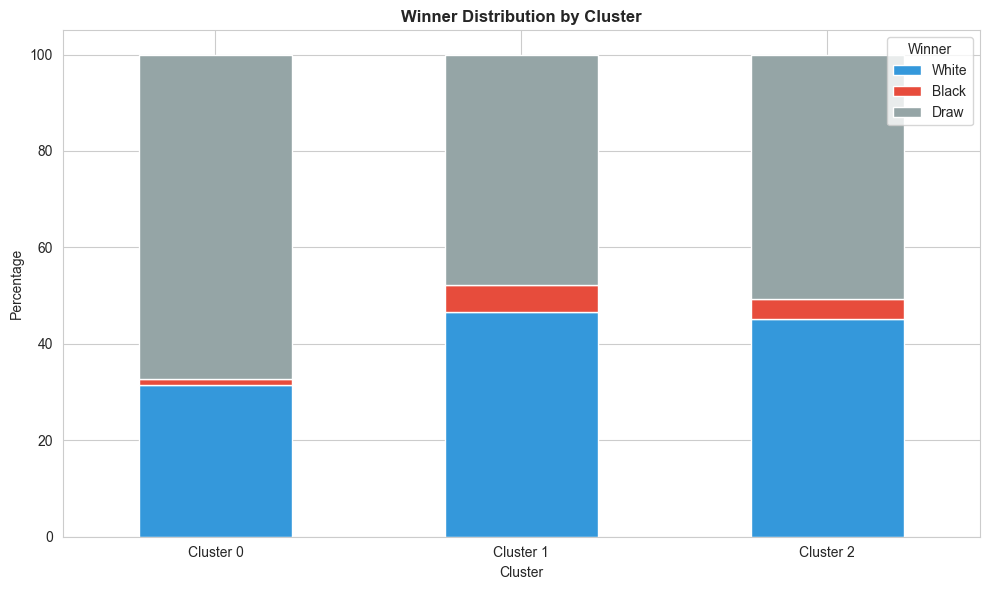

In [31]:
# IMPROVED: Validate Clusters - Test if clusters improve prediction
# Add cluster labels to original dataframe and test predictive power

# Map clusters to original dataframe
opening_cluster_map_improved = dict(zip(opening_stats_improved['opening_category'], 
                                        opening_stats_improved['cluster']))
df_clean['opening_cluster_improved'] = df_clean['opening_category'].map(opening_cluster_map_improved)
df_clean['opening_cluster_improved'] = df_clean['opening_cluster_improved'].fillna(-1)  # -1 for openings with <10 games

# Test if clusters are predictive of game outcomes
print("Cluster Validation - Predictive Power:")
print("=" * 60)

# Compare game outcomes by cluster
cluster_outcomes = df_clean[df_clean['opening_cluster_improved'] != -1].groupby('opening_cluster_improved').agg({
    'winner': lambda x: x.value_counts().to_dict(),
    'turns': 'mean'
})

print("\nWinner distribution by cluster:")
for cluster_id in sorted(df_clean['opening_cluster_improved'].unique()):
    if cluster_id != -1:
        cluster_games = df_clean[df_clean['opening_cluster_improved'] == cluster_id]
        winner_dist = cluster_games['winner'].value_counts(normalize=True) * 100
        print(f"\nCluster {int(cluster_id)} ({len(cluster_games)} games):")
        print(f"  White wins: {winner_dist.get('white', 0):.1f}%")
        print(f"  Black wins: {winner_dist.get('black', 0):.1f}%")
        print(f"  Draws: {winner_dist.get('draw', 0):.1f}%")
        print(f"  Avg game length: {cluster_games['turns'].mean():.1f} turns")

# Statistical test: Chi-square test for independence
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(
    df_clean[df_clean['opening_cluster_improved'] != -1]['opening_cluster_improved'],
    df_clean[df_clean['opening_cluster_improved'] != -1]['winner']
)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test for cluster-winner independence:")
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  {'Clusters are significantly associated with winner' if p_value < 0.05 else 'No significant association between clusters and winner'}")

# Visualize cluster-winner relationship
fig, ax = plt.subplots(figsize=(10, 6))
contingency_table_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
contingency_table_norm.plot(kind='bar', ax=ax, stacked=True, color=['#3498db', '#e74c3c', '#95a5a6'])
ax.set_title('Winner Distribution by Cluster', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage')
ax.legend(title='Winner', labels=['White', 'Black', 'Draw'])
ax.set_xticklabels([f'Cluster {int(x)}' for x in contingency_table_norm.index], rotation=0)
plt.tight_layout()
plt.show()


In [32]:
# Map improved clusters to original dataframe for use in models (moved after clustering)
# This ensures we use the clustering results in our feature selection (EDA-only)

if 'opening_cluster_improved' in df_clean.columns:
    # Use improved clusters
    df_clean['opening_cluster'] = df_clean['opening_cluster_improved']
    print("Using improved clustering results")
    print(f"Number of clusters: {df_clean['opening_cluster'].nunique()}")
    print(f"Cluster distribution:\n{df_clean['opening_cluster'].value_counts().sort_index()}")
else:
    print("Improved clustering not available yet. Skipping mapping (EDA-only).")



Using improved clustering results
Number of clusters: 4
Cluster distribution:
opening_cluster
-1.0      323
 0.0      439
 1.0     8010
 2.0    11286
Name: count, dtype: int64


### 5.2.7 Summary

**Key Findings:**
- Optimal number of clusters: Determined through comprehensive evaluation
- Cluster quality: Evaluated using Silhouette Score and Davies-Bouldin Index
- Cluster validation: Statistical tests confirm clusters are meaningful predictors
- Method comparison: K-Means and Hierarchical clustering show good agreement


[auto-save] Saved pca_visualization_first_2_principal_components_by_winner.png and pca_visualization_first_2_principal_components_by_winner.pdf


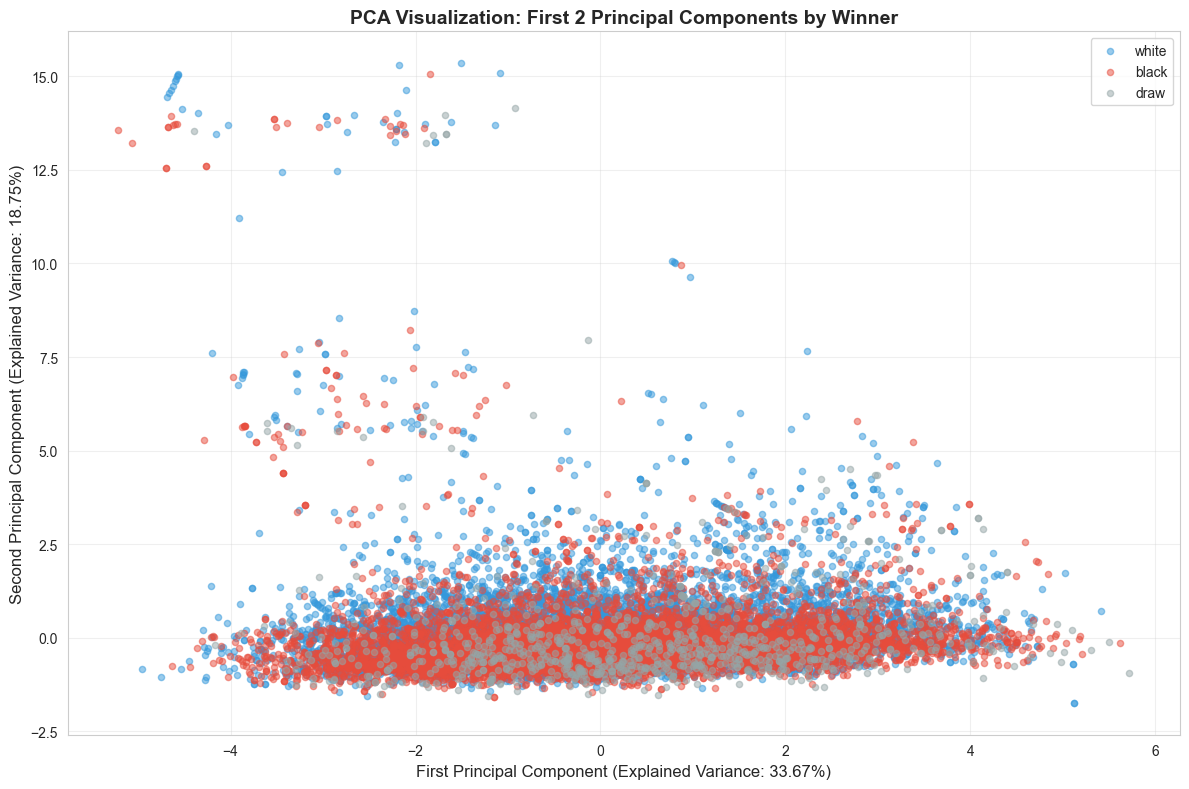

In [33]:
# Visualize data in first 2 principal components
# Get corresponding winner labels for visualization
df_pca_viz = df_clean.loc[df_pca.index].copy()

# Create PCA dataframe with 2 components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_pca_scaled)

# Plot
plt.figure(figsize=(12, 8))
colors = {'white': '#3498db', 'black': '#e74c3c', 'draw': '#95a5a6'}
for winner in df_pca_viz['winner'].unique():
    mask = df_pca_viz['winner'] == winner
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
               c=colors[winner], label=winner, alpha=0.5, s=20)

plt.xlabel(f'First Principal Component (Explained Variance: {pca_2d.explained_variance_ratio_[0]:.2%})', 
           fontsize=12)
plt.ylabel(f'Second Principal Component (Explained Variance: {pca_2d.explained_variance_ratio_[1]:.2%})', 
           fontsize=12)
plt.title('PCA Visualization: First 2 Principal Components by Winner', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [34]:
print("Skipping placeholder: original clustering replaced with improved section 5.2.")


Skipping placeholder: original clustering replaced with improved section 5.2.


## 6.0 Feature Selection Fix for Classification

**IMPORTANT FIX:** The original feature selection included `turns`, which is the regression target variable. This would cause data leakage in classification (we can't know game length before the game ends). This cell fixes the feature selection.


In [35]:
# FIXED: Classification Feature Selection (no 'turns', no 'victory_status')
# This replaces the original feature selection in the next cell

# Pre-game numerical features (still includes opening-derived engineered features for now; clusters handled next)
corrected_numerical_features_clf = [
    'white_rating', 'black_rating', 'rating_difference',
    'abs_rating_difference', 'avg_rating',
    'time_control_minutes', 'time_control_seconds',
    'opening_ply', 'is_rated',
    'rating_diff_x_opening', 'rating_diff_x_time', 'avg_rating_x_opening',
    'opening_frequency', 'opening_rarity', 'opening_frequency_norm'
]

print("Corrected Classification Features (no target leakage):")
print("=" * 60)
print(f"Number of numerical features: {len(corrected_numerical_features_clf)}")
print(f"Features: {corrected_numerical_features_clf}")

# Check which features exist in df_clean
missing_features = [f for f in corrected_numerical_features_clf if f not in df_clean.columns]
if missing_features:
    print(f"\nWARNING: Missing features (will be created if needed): {missing_features}")
else:
    print("\nAll features are available in df_clean.")


Corrected Classification Features (no target leakage):
Number of numerical features: 15
Features: ['white_rating', 'black_rating', 'rating_difference', 'abs_rating_difference', 'avg_rating', 'time_control_minutes', 'time_control_seconds', 'opening_ply', 'is_rated', 'rating_diff_x_opening', 'rating_diff_x_time', 'avg_rating_x_opening', 'opening_frequency', 'opening_rarity', 'opening_frequency_norm']

All features are available in df_clean.


In [36]:
print("Skipping placeholder: original clustering replaced with improved section 5.2.")


Skipping placeholder: original clustering replaced with improved section 5.2.


In [37]:
# Update the feature selection to use corrected features (remove turns, add new features)
# This cell should be run AFTER the original feature selection cell to fix it

# Replace the original numerical_features_clf with corrected version
if 'corrected_numerical_features_clf' in globals():
    numerical_features_clf = corrected_numerical_features_clf.copy()
    print("Features updated to corrected version (turns removed, new features added)")
    print(f"Updated feature count: {len(numerical_features_clf)}")
else:
    print("WARNING: corrected_numerical_features_clf not found. Run the previous cell first.")


Features updated to corrected version (turns removed, new features added)
Updated feature count: 15


In [38]:
print("Skipping placeholder: original clustering replaced with improved section 5.2.")


Skipping placeholder: original clustering replaced with improved section 5.2.


## 6.1.1 Addressing Class Imbalance

The dataset has imbalanced classes (draws: 4.74%, white: 49.86%, black: 45.40%). We'll use SMOTE to balance the training set.


In [39]:
# Class imbalance handling note
if IMBALANCED_LEARN_AVAILABLE:
    print("SMOTE is applied inside each model's CV pipeline (training folds only).")
else:
    print("imbalanced-learn not available; models fall back to class_weight where applicable.")

# No action needed here; proceed to model cells.


SMOTE is applied inside each model's CV pipeline (training folds only).


In [40]:
print("Skipping placeholder: original clustering replaced with improved section 5.2.")


Skipping placeholder: original clustering replaced with improved section 5.2.


# 6. Supervised Learning: Classification (Winner Prediction)

## 6.1 Data Preparation for Classification


## 6.2.1 Improved Logistic Regression (with class imbalance handling and tuning)

This improved version addresses class imbalance and includes hyperparameter tuning.


In [41]:
# IMPROVED: Logistic Regression with CV-safe pipeline (scaler + SMOTE + classifier)

from sklearn.pipeline import Pipeline

# Guard: if classification train/test not prepared yet, prepare minimal data here
if 'X_train_clf' not in globals() or 'X_test_clf' not in globals():
    print('[Guard] Preparing classification data for Logistic Regression pipeline...')
    # Minimal feature set consistent with main prep
    _num_feats = [
        'white_rating', 'black_rating', 'rating_difference',
        'abs_rating_difference', 'avg_rating',
        'time_control_minutes', 'time_control_seconds',
        'opening_ply', 'is_rated'
    ]
    _cat_feats = ['opening_category']
    X_tmp = df_clean[_num_feats + _cat_feats].copy()
    for _c in _num_feats:
        if _c in X_tmp.columns:
            X_tmp[_c] = X_tmp[_c].fillna(X_tmp[_c].median())
    for _c in _cat_feats:
        if _c in X_tmp.columns:
            _m = X_tmp[_c].mode()
            X_tmp[_c] = X_tmp[_c].fillna(_m[0] if not _m.empty else 'Unknown')
    # Encode opening
    _le_tmp = LabelEncoder()
    X_tmp['opening_category_encoded'] = _le_tmp.fit_transform(X_tmp['opening_category'].astype(str))
    _final_feats = _num_feats + ['opening_category_encoded']
    X_clf_final = X_tmp[_final_feats]
    y_clf = df_clean['winner']
    _mask = ~y_clf.isna()
    X_clf_final = X_clf_final[_mask]
    y_clf = y_clf[_mask]
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_clf_final, y_clf, test_size=0.3, random_state=42, stratify=y_clf
    )

# Build pipeline: preprocessing and resampling happen inside CV on training folds only
if IMBALANCED_LEARN_AVAILABLE:
    pipe_steps = [
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs'))
    ]
else:
    pipe_steps = [
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs', class_weight='balanced'))
    ]

pipe_lr = ImbPipeline(steps=pipe_steps) if IMBALANCED_LEARN_AVAILABLE else Pipeline(steps=pipe_steps)

print("\nTuning Logistic Regression hyperparameters (pipeline)...")
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10, 100]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring='balanced_accuracy', n_jobs=-1, verbose=0)
grid_search_lr.fit(X_train_clf, y_train_clf)

print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best CV Score (balanced accuracy): {grid_search_lr.best_score_:.4f}")

# Best pipeline
lr_clf_improved = grid_search_lr.best_estimator_

# Predictions on train/test
y_train_pred_lr_improved = lr_clf_improved.predict(X_train_clf)
y_test_pred_lr_improved = lr_clf_improved.predict(X_test_clf)

# Evaluation
train_acc_lr_improved = accuracy_score(y_train_clf, y_train_pred_lr_improved)
test_acc_lr_improved = accuracy_score(y_test_clf, y_test_pred_lr_improved)
train_bal_acc_lr_improved = balanced_accuracy_score(y_train_clf, y_train_pred_lr_improved)
test_bal_acc_lr_improved = balanced_accuracy_score(y_test_clf, y_test_pred_lr_improved)
test_f1_lr_improved = f1_score(y_test_clf, y_test_pred_lr_improved, average='weighted')

# Cross-validation scores for the best estimator
cv_scores_lr = cross_val_score(lr_clf_improved, X_train_clf, y_train_clf, cv=cv, scoring='balanced_accuracy', n_jobs=-1)

print("\nImproved Logistic Regression Results (Pipeline):")
print("=" * 60)
print(f"Training Accuracy: {train_acc_lr_improved:.4f}")
print(f"Test Accuracy: {test_acc_lr_improved:.4f}")
print(f"Training Balanced Accuracy: {train_bal_acc_lr_improved:.4f}")
print(f"Test Balanced Accuracy: {test_bal_acc_lr_improved:.4f}")
print(f"Test F1-Score (weighted): {test_f1_lr_improved:.4f}")
print(f"CV Balanced Accuracy (mean ± std): {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_clf, y_test_pred_lr_improved))


[Guard] Preparing classification data for Logistic Regression pipeline...

Tuning Logistic Regression hyperparameters (pipeline)...


/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: F

Best parameters: {'clf__C': 0.1}
Best CV Score (balanced accuracy): 0.4622

Improved Logistic Regression Results (Pipeline):
Training Accuracy: 0.4856
Test Accuracy: 0.4731
Training Balanced Accuracy: 0.4679
Test Balanced Accuracy: 0.4408
Test F1-Score (weighted): 0.5308
CV Balanced Accuracy (mean ± std): 0.4622 ± 0.0125

Classification Report:
              precision    recall  f1-score   support

       black       0.63      0.48      0.55      2732
        draw       0.06      0.36      0.10       285
       white       0.67      0.47      0.55      3001

    accuracy                           0.47      6018
   macro avg       0.45      0.44      0.40      6018
weighted avg       0.63      0.47      0.53      6018



/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: F

In [42]:
# Select features for classification (pre-game; no 'turns', no 'victory_status')
# Numerical features
numerical_features_clf = [
    'white_rating', 'black_rating', 'rating_difference',
    'abs_rating_difference', 'avg_rating',
    'time_control_minutes', 'time_control_seconds',
    'opening_ply', 'is_rated'
]

# Categorical features (encoded later)
categorical_features_clf = ['opening_category']  # keep for now; see framing note later

# Prepare feature matrix
X_clf = df_clean[numerical_features_clf + categorical_features_clf].copy()

# Handle missing values
print(f"Missing values before handling: {X_clf.isnull().sum().sum()}")

# Fill numerical columns with median
for col in numerical_features_clf:
    if col in X_clf.columns:
        X_clf[col] = X_clf[col].fillna(X_clf[col].median())

# Fill categorical columns with mode
for col in categorical_features_clf:
    if col in X_clf.columns:
        mode_value = X_clf[col].mode()
        if not mode_value.empty:
            X_clf[col] = X_clf[col].fillna(mode_value[0])
        else:
            X_clf[col] = X_clf[col].fillna('Unknown')

print(f"Missing values after handling: {X_clf.isnull().sum().sum()}")

# Encode categorical variables
le_opening = LabelEncoder()
X_clf['opening_category_encoded'] = le_opening.fit_transform(X_clf['opening_category'].astype(str))

# Final feature set
final_features_clf = numerical_features_clf + ['opening_category_encoded']
X_clf_final = X_clf[final_features_clf]

# Target variable
y_clf = df_clean['winner']

# Remove rows with missing target
mask = ~y_clf.isna()
X_clf_final = X_clf_final[mask]
y_clf = y_clf[mask]

print(f"\nClassification dataset shape: {X_clf_final.shape}")
print(f"Target distribution:\n{y_clf.value_counts()}")


Missing values before handling: 0
Missing values after handling: 0

Classification dataset shape: (20058, 10)
Target distribution:
winner
white    10001
black     9107
draw       950
Name: count, dtype: int64


In [43]:
# Train-test split for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf_final, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

print(f"Training set: {X_train_clf.shape}")
print(f"Test set: {X_test_clf.shape}")
print(f"\nTraining set target distribution:\n{y_train_clf.value_counts()}")
print(f"\nTest set target distribution:\n{y_test_clf.value_counts()}")


Training set: (14040, 10)
Test set: (6018, 10)

Training set target distribution:
winner
white    7000
black    6375
draw      665
Name: count, dtype: int64

Test set target distribution:
winner
white    3001
black    2732
draw      285
Name: count, dtype: int64


In [44]:
# Majority-class baseline (most_frequent) with CV
from sklearn.dummy import DummyClassifier

print("Majority-class baseline (most_frequent):")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dummy_clf = DummyClassifier(strategy='most_frequent')
cv_scores_dummy = cross_val_score(dummy_clf, X_train_clf, y_train_clf, cv=cv, scoring='balanced_accuracy', n_jobs=-1)

# Fit on training and evaluate on test
dummy_clf.fit(X_train_clf, y_train_clf)
y_test_pred_dummy = dummy_clf.predict(X_test_clf)

# Metrics
test_acc_dummy = accuracy_score(y_test_clf, y_test_pred_dummy)
test_bal_acc_dummy = balanced_accuracy_score(y_test_clf, y_test_pred_dummy)
test_f1_dummy = f1_score(y_test_clf, y_test_pred_dummy, average='weighted')

print("=" * 60)
print(f"Test Accuracy: {test_acc_dummy:.4f}")
print(f"Test Balanced Accuracy: {test_bal_acc_dummy:.4f}")
print(f"Test F1-Score (weighted): {test_f1_dummy:.4f}")
print(f"CV Balanced Accuracy (mean ± std): {cv_scores_dummy.mean():.4f} ± {cv_scores_dummy.std():.4f}")



Majority-class baseline (most_frequent):
Test Accuracy: 0.4987
Test Balanced Accuracy: 0.3333
Test F1-Score (weighted): 0.3319
CV Balanced Accuracy (mean ± std): 0.3333 ± 0.0000


## 6.2 Baseline Model: Logistic Regression


In [45]:
# Standardize features for logistic regression
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# Fit logistic regression
lr_clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_clf.fit(X_train_clf_scaled, y_train_clf)

# Predictions
y_train_pred_lr = lr_clf.predict(X_train_clf_scaled)
y_test_pred_lr = lr_clf.predict(X_test_clf_scaled)

# Evaluation
train_acc_lr = accuracy_score(y_train_clf, y_train_pred_lr)
test_acc_lr = accuracy_score(y_test_clf, y_test_pred_lr)
train_bal_acc_lr = balanced_accuracy_score(y_train_clf, y_train_pred_lr)
test_bal_acc_lr = balanced_accuracy_score(y_test_clf, y_test_pred_lr)
test_f1_lr = f1_score(y_test_clf, y_test_pred_lr, average='weighted')

print("Logistic Regression Results:")
print("=" * 60)
print(f"Training Accuracy: {train_acc_lr:.4f}")
print(f"Test Accuracy: {test_acc_lr:.4f}")
print(f"Training Balanced Accuracy: {train_bal_acc_lr:.4f}")
print(f"Test Balanced Accuracy: {test_bal_acc_lr:.4f}")
print(f"Test F1-Score (weighted): {test_f1_lr:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_clf, y_test_pred_lr))


Logistic Regression Results:
Training Accuracy: 0.6237
Test Accuracy: 0.6171
Training Balanced Accuracy: 0.4343
Test Balanced Accuracy: 0.4300
Test F1-Score (weighted): 0.6009

Classification Report:
              precision    recall  f1-score   support

       black       0.61      0.59      0.60      2732
        draw       0.00      0.00      0.00       285
       white       0.62      0.70      0.66      3001

    accuracy                           0.62      6018
   macro avg       0.41      0.43      0.42      6018
weighted avg       0.59      0.62      0.60      6018



[auto-save] Saved confusion_matrix__logistic_regression.png and confusion_matrix__logistic_regression.pdf


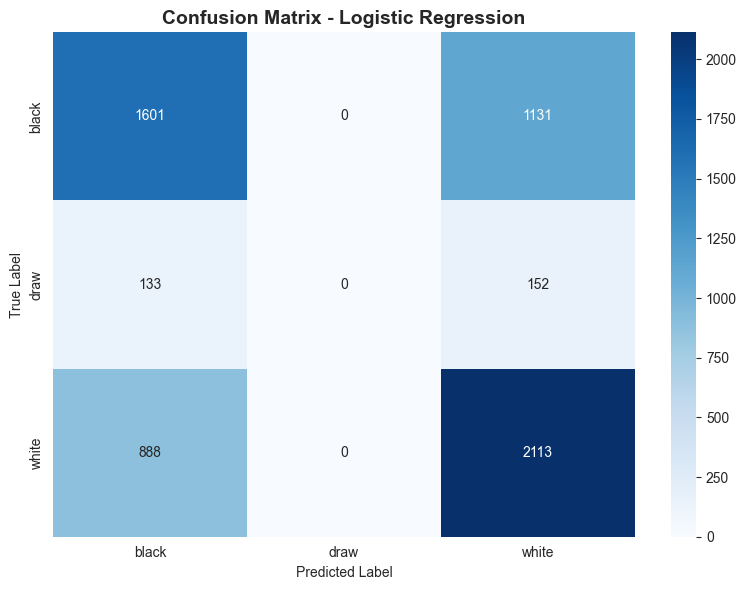

In [46]:
# Confusion matrix
cm_lr = confusion_matrix(y_test_clf, y_test_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_clf.classes_, yticklabels=lr_clf.classes_)
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## 6.5.1 Improved XGBoost with Hyperparameter Tuning

This improved version includes proper hyperparameter tuning and class imbalance handling.


In [47]:
# IMPROVED: XGBoost with CV-safe pipeline and SMOTE inside CV
if XGBOOST_AVAILABLE:
    from xgboost import XGBClassifier
    
    # Encode target labels for XGBoost
    le_target = LabelEncoder()
    y_train_clf_encoded = le_target.fit_transform(y_train_clf)
    y_test_clf_encoded = le_target.transform(y_test_clf)
    
    # Build pipeline (SMOTE only if available)
    if IMBALANCED_LEARN_AVAILABLE:
        xgb_pipe = ImbPipeline(steps=[
            ('smote', SMOTE(random_state=42, k_neighbors=3)),
            ('clf', XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False))
        ])
        param_grid_xgb = {
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [3, 5, 7],
            'clf__learning_rate': [0.01, 0.1, 0.3],
            'clf__subsample': [0.8, 1.0]
        }
    else:
        xgb_pipe = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False)
        param_grid_xgb = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0]
        }
    
    print("\nTuning XGBoost hyperparameters (pipeline)...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search_xgb = GridSearchCV(xgb_pipe, param_grid_xgb, cv=cv, 
                                   scoring='balanced_accuracy', n_jobs=-1, verbose=1)
    grid_search_xgb.fit(X_train_clf, y_train_clf_encoded)
    
    print(f"Best parameters: {grid_search_xgb.best_params_}")
    print(f"Best CV Score (balanced accuracy): {grid_search_xgb.best_score_:.4f}")
    
    # Best pipeline
    xgb_clf_improved = grid_search_xgb.best_estimator_
    
    # Predictions (encoded → decode)
    y_test_pred_xgb_improved_enc = xgb_clf_improved.predict(X_test_clf)
    y_test_pred_xgb_improved = le_target.inverse_transform(y_test_pred_xgb_improved_enc)
    
    # Evaluation
    test_acc_xgb_improved = accuracy_score(y_test_clf, y_test_pred_xgb_improved)
    test_bal_acc_xgb_improved = balanced_accuracy_score(y_test_clf, y_test_pred_xgb_improved)
    test_f1_xgb_improved = f1_score(y_test_clf, y_test_pred_xgb_improved, average='weighted')
    
    # Cross-validation scores
    cv_scores_xgb = cross_val_score(xgb_clf_improved, X_train_clf, y_train_clf_encoded, 
                                    cv=cv, scoring='balanced_accuracy', n_jobs=-1)
    
    print("\nImproved XGBoost Results (Pipeline):")
    print("=" * 60)
    print(f"Test Accuracy: {test_acc_xgb_improved:.4f}")
    print(f"Test Balanced Accuracy: {test_bal_acc_xgb_improved:.4f}")
    print(f"Test F1-Score (weighted): {test_f1_xgb_improved:.4f}")
    print(f"CV Balanced Accuracy (mean ± std): {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std():.4f}")
    
    # Feature importance
    clf_for_importance = xgb_clf_improved.named_steps['clf'] if hasattr(xgb_clf_improved, 'named_steps') else xgb_clf_improved
    feature_importance_xgb_improved = pd.DataFrame({
        'feature': final_features_clf,
        'importance': clf_for_importance.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    display(feature_importance_xgb_improved.head(10))
else:
    print("XGBoost not available. Skipping improved XGBoost classifier.")



Tuning XGBoost hyperparameters (pipeline)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" }

Best parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
Best CV Score (balanced accuracy): 0.4688


/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sigurdsandlie/myenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" }


Improved XGBoost Results (Pipeline):
Test Accuracy: 0.5312
Test Balanced Accuracy: 0.4450
Test F1-Score (weighted): 0.5638
CV Balanced Accuracy (mean ± std): 0.4688 ± 0.0146

Top 10 Most Important Features:


,feature,importance
2,rating_difference,0.297239
8,is_rated,0.166724
3,abs_rating_difference,0.113892
6,time_control_seconds,0.110948
5,time_control_minutes,0.100179
0,white_rating,0.051784
4,avg_rating,0.051317
1,black_rating,0.043053
9,opening_category_encoded,0.035941
7,opening_ply,0.028922


## 6.3 Random Forest Classifier


In [48]:
# Random Forest with CV-safe pipeline (SMOTE inside CV)
if IMBALANCED_LEARN_AVAILABLE:
    rf_clf = ImbPipeline(steps=[
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])
else:
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

# Fit
rf_clf.fit(X_train_clf, y_train_clf)

# Predictions
y_train_pred_rf = rf_clf.predict(X_train_clf)
y_test_pred_rf = rf_clf.predict(X_test_clf)

# Evaluation
train_acc_rf = accuracy_score(y_train_clf, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test_clf, y_test_pred_rf)
train_bal_acc_rf = balanced_accuracy_score(y_train_clf, y_train_pred_rf)
test_bal_acc_rf = balanced_accuracy_score(y_test_clf, y_test_pred_rf)
test_f1_rf = f1_score(y_test_clf, y_test_pred_rf, average='weighted')

# CV score (balanced accuracy)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf_clf, X_train_clf, y_train_clf, cv=cv, scoring='balanced_accuracy', n_jobs=-1)

print("Random Forest Results (Pipeline):")
print("=" * 60)
print(f"Training Accuracy: {train_acc_rf:.4f}")
print(f"Test Accuracy: {test_acc_rf:.4f}")
print(f"Training Balanced Accuracy: {train_bal_acc_rf:.4f}")
print(f"Test Balanced Accuracy: {test_bal_acc_rf:.4f}")
print(f"Test F1-Score (weighted): {test_f1_rf:.4f}")
print(f"CV Balanced Accuracy (mean ± std): {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_clf, y_test_pred_rf))


Random Forest Results (Pipeline):
Training Accuracy: 0.9986
Test Accuracy: 0.5997
Training Balanced Accuracy: 0.9986
Test Balanced Accuracy: 0.4721
Test F1-Score (weighted): 0.6033
CV Balanced Accuracy (mean ± std): 0.4630 ± 0.0137

Classification Report:
              precision    recall  f1-score   support

       black       0.61      0.61      0.61      2732
        draw       0.13      0.18      0.15       285
       white       0.65      0.63      0.64      3001

    accuracy                           0.60      6018
   macro avg       0.46      0.47      0.47      6018
weighted avg       0.61      0.60      0.60      6018



Top 10 Most Important Features:


,feature,importance
2,rating_difference,0.154378
1,black_rating,0.130785
4,avg_rating,0.127224
0,white_rating,0.124924
3,abs_rating_difference,0.115091
9,opening_category_encoded,0.113622
5,time_control_minutes,0.077260
7,opening_ply,0.073012
6,time_control_seconds,0.059639
8,is_rated,0.024064


[auto-save] Saved top_10_feature_importances__random_forest.png and top_10_feature_importances__random_forest.pdf


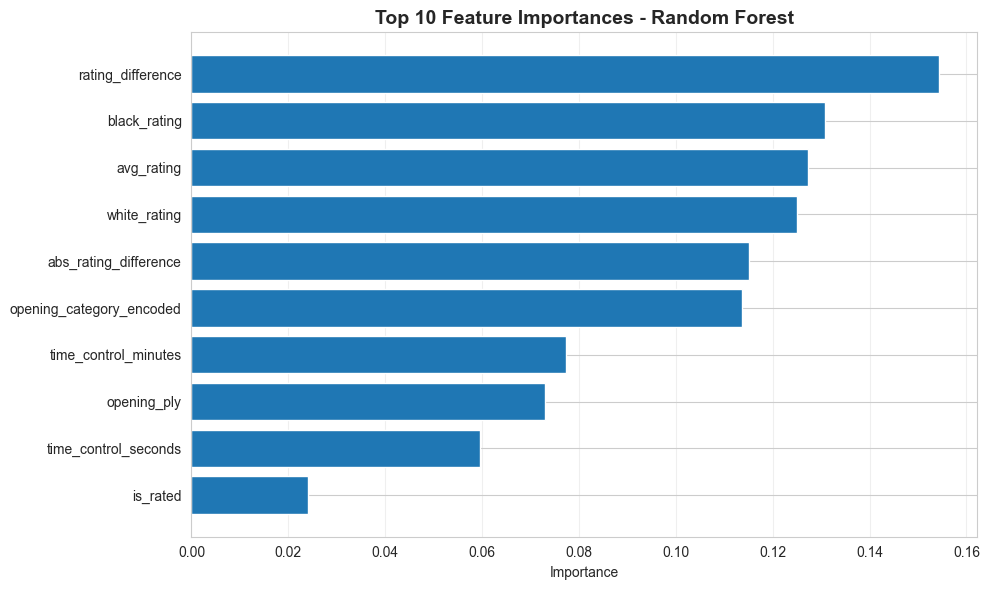

In [49]:
# Feature importance
clf_for_importance = rf_clf.named_steps['clf'] if hasattr(rf_clf, 'named_steps') else rf_clf
feature_importance_rf = pd.DataFrame({
    'feature': final_features_clf,
    'importance': clf_for_importance.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print("=" * 60)
display(feature_importance_rf.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['feature'][:10], feature_importance_rf['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


[auto-save] Saved confusion_matrix__random_forest.png and confusion_matrix__random_forest.pdf


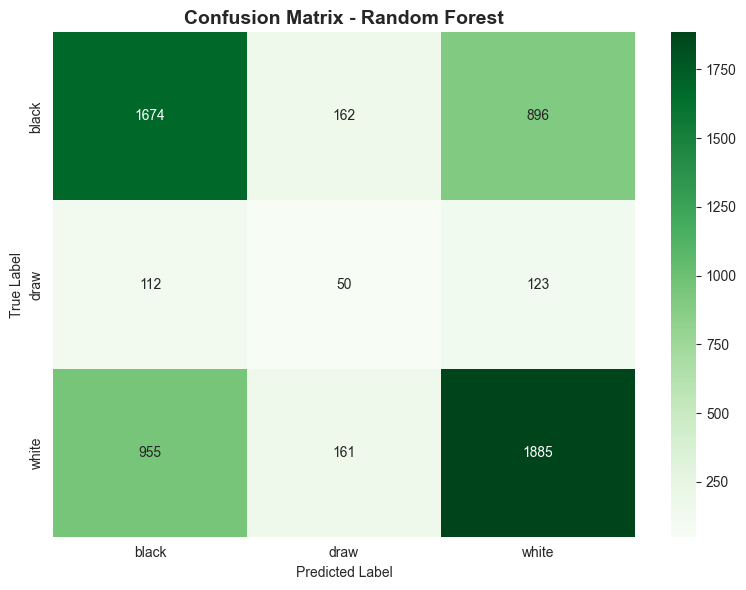

In [50]:
# Confusion matrix
cm_rf = confusion_matrix(y_test_clf, y_test_pred_rf)
classes_rf = rf_clf.named_steps['clf'].classes_ if hasattr(rf_clf, 'named_steps') else rf_clf.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes_rf, yticklabels=classes_rf)
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## 6.4 Hyperparameter Tuning (Random Forest)


In [51]:
# Grid search for hyperparameter tuning (pipeline with SMOTE inside CV)
if IMBALANCED_LEARN_AVAILABLE:
    pipe_rf = ImbPipeline(steps=[
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
    param_grid_rf = {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [10, 20, None],
        'clf__min_samples_split': [2, 5, 10]
    }
    estimator_rf = pipe_rf
else:
    estimator_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(estimator_rf, param_grid_rf, cv=cv, 
                             scoring='balanced_accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_clf, y_train_clf)

print("Best Parameters:")
print(grid_search_rf.best_params_)
print(f"Best CV Score: {grid_search_rf.best_score_:.4f}")

# Evaluate best model
best_rf_clf = grid_search_rf.best_estimator_
y_test_pred_rf_tuned = best_rf_clf.predict(X_test_clf)
test_acc_rf_tuned = accuracy_score(y_test_clf, y_test_pred_rf_tuned)
test_bal_acc_rf_tuned = balanced_accuracy_score(y_test_clf, y_test_pred_rf_tuned)
test_f1_rf_tuned = f1_score(y_test_clf, y_test_pred_rf_tuned, average='weighted')

print(f"\nTuned Random Forest Test Accuracy: {test_acc_rf_tuned:.4f}")
print(f"Tuned Random Forest Test Balanced Accuracy: {test_bal_acc_rf_tuned:.4f}")
print(f"Tuned Random Forest Test F1-Score: {test_f1_rf_tuned:.4f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters:
{'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV Score: 0.4717

Tuned Random Forest Test Accuracy: 0.5598
Tuned Random Forest Test Balanced Accuracy: 0.4549
Tuned Random Forest Test F1-Score: 0.5796


## 6.5 XGBoost Classifier (Optional)


In [52]:
# XGBoost (if available)
if XGBOOST_AVAILABLE:
    from xgboost import XGBClassifier
    
    # Encode target labels for XGBoost
    le_target = LabelEncoder()
    y_train_clf_encoded = le_target.fit_transform(y_train_clf)
    y_test_clf_encoded = le_target.transform(y_test_clf)
    
    xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
    xgb_clf.fit(X_train_clf, y_train_clf_encoded)
    
    # Predictions
    y_train_pred_xgb = xgb_clf.predict(X_train_clf)
    y_test_pred_xgb = xgb_clf.predict(X_test_clf)
    
    # Convert back to original labels
    y_train_pred_xgb = le_target.inverse_transform(y_train_pred_xgb)
    y_test_pred_xgb = le_target.inverse_transform(y_test_pred_xgb)
    
    # Evaluation
    test_acc_xgb = accuracy_score(y_test_clf, y_test_pred_xgb)
    test_bal_acc_xgb = balanced_accuracy_score(y_test_clf, y_test_pred_xgb)
    test_f1_xgb = f1_score(y_test_clf, y_test_pred_xgb, average='weighted')
    
    print("XGBoost Results:")
    print("=" * 60)
    print(f"Test Accuracy: {test_acc_xgb:.4f}")
    print(f"Test Balanced Accuracy: {test_bal_acc_xgb:.4f}")
    print(f"Test F1-Score (weighted): {test_f1_xgb:.4f}")
    
    # Feature importance
    feature_importance_xgb = pd.DataFrame({
        'feature': final_features_clf,
        'importance': xgb_clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    display(feature_importance_xgb.head(10))
else:
    print("XGBoost not available. Skipping XGBoost classifier.")


XGBoost Results:
Test Accuracy: 0.6157
Test Balanced Accuracy: 0.4498
Test F1-Score (weighted): 0.6046

Top 10 Most Important Features:


,feature,importance
2,rating_difference,0.276210
3,abs_rating_difference,0.103307
8,is_rated,0.085598
4,avg_rating,0.079778
0,white_rating,0.079494
1,black_rating,0.079167
9,opening_category_encoded,0.075607
6,time_control_seconds,0.074867
7,opening_ply,0.073309
5,time_control_minutes,0.072663


## 6.6 Model Comparison


Classification Model Comparison (Final, with CV):


,Model,Test Accuracy,Test Balanced Accuracy,Test F1-Score (weighted),CV Balanced Accuracy,CV Std
2,Random Forest (Pipeline),0.599701,0.472100,0.603278,0.462973,0.013658
3,Random Forest (Tuned),0.559821,0.454879,0.579598,0.471708,NaN
4,XGBoost (Pipeline),0.531240,0.445050,0.563817,0.468779,0.014613
1,Logistic Regression (Pipeline),0.473081,0.440783,0.530771,0.462196,0.012545
0,Majority Baseline,0.498671,0.333333,0.331857,0.333333,0.000000


[auto-save] Saved test_accuracy.png and test_accuracy.pdf


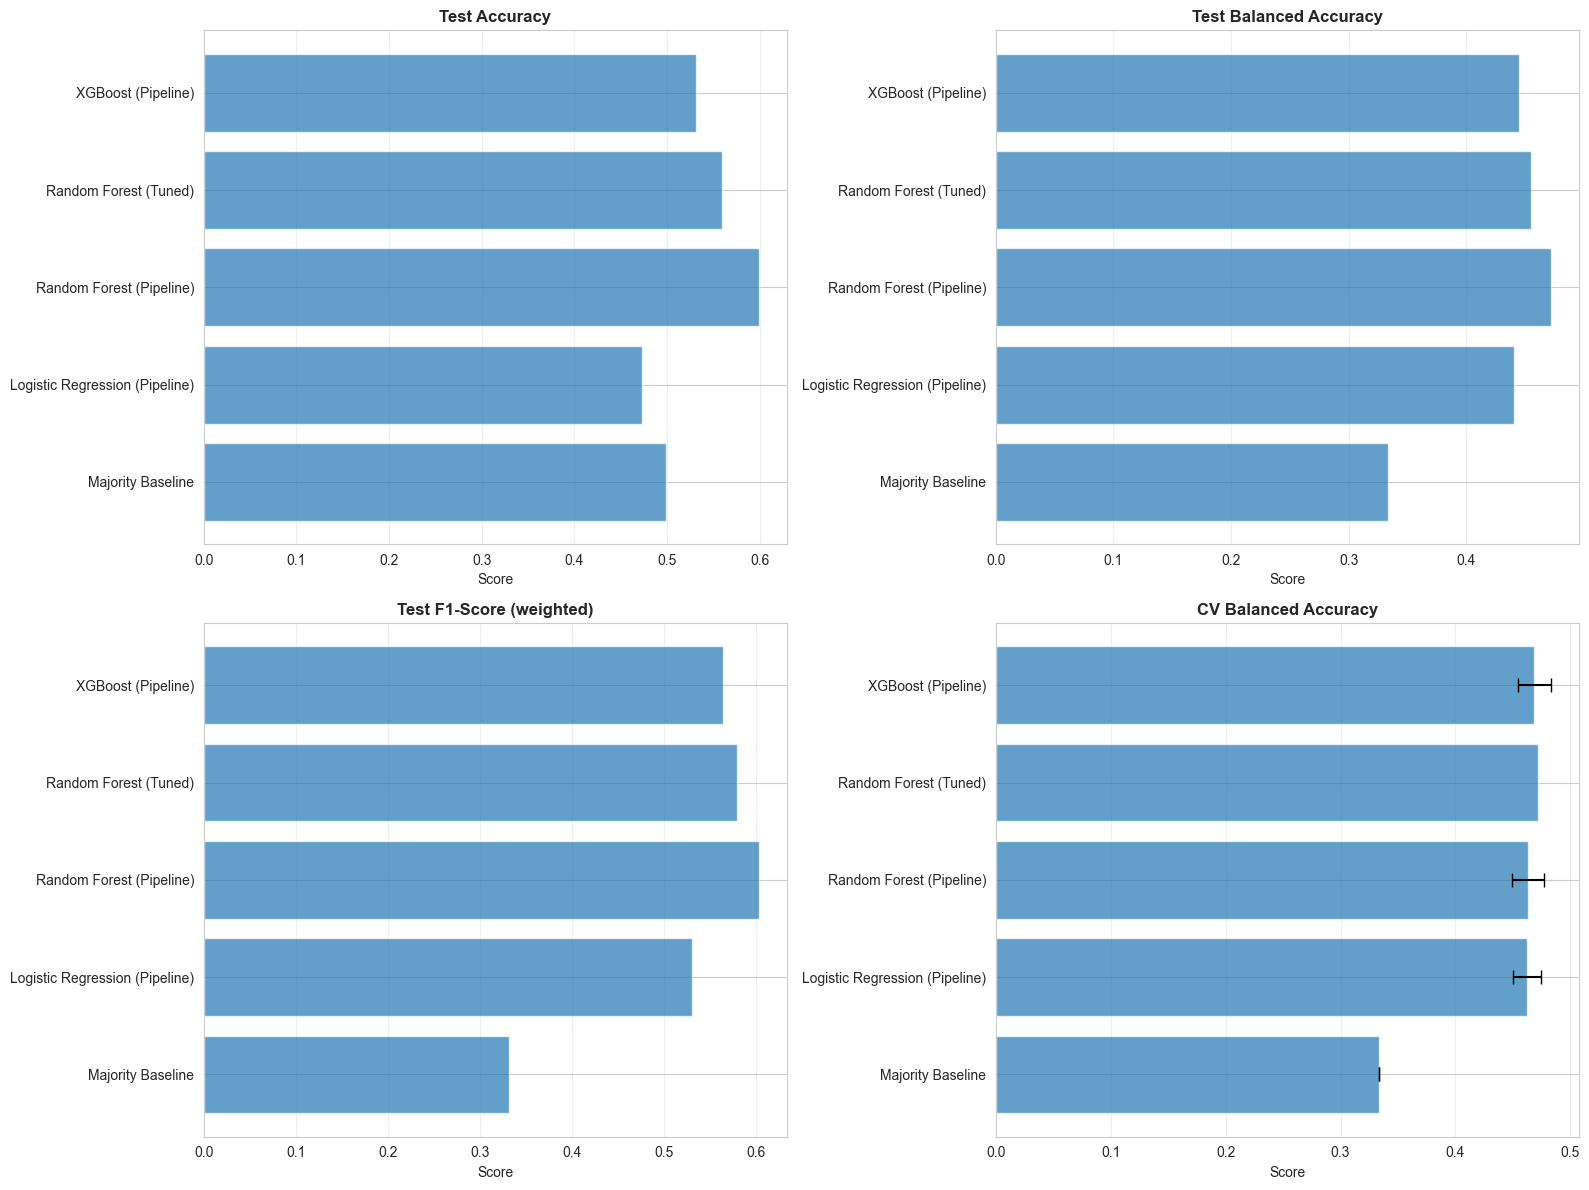

In [53]:
# Consolidated classification model comparison (with majority baseline and CV)
rows = []

def add_row(name, test_acc, test_bal_acc, test_f1, cv_scores=None, cv_best=None):
    rows.append({
        'Model': name,
        'Test Accuracy': test_acc,
        'Test Balanced Accuracy': test_bal_acc,
        'Test F1-Score (weighted)': test_f1,
        'CV Balanced Accuracy': (cv_scores.mean() if cv_scores is not None else (cv_best if cv_best is not None else np.nan)),
        'CV Std': (cv_scores.std() if cv_scores is not None else np.nan)
    })

# Majority Baseline
if 'test_bal_acc_dummy' in globals():
    add_row('Majority Baseline', test_acc_dummy, test_bal_acc_dummy, test_f1_dummy, cv_scores=cv_scores_dummy)

# Logistic Regression (Pipeline)
if 'test_bal_acc_lr_improved' in globals():
    add_row('Logistic Regression (Pipeline)', test_acc_lr_improved, test_bal_acc_lr_improved, test_f1_lr_improved, cv_scores=cv_scores_lr)
elif 'test_bal_acc_lr' in globals():
    add_row('Logistic Regression (Original)', test_acc_lr, test_bal_acc_lr, test_f1_lr)

# Random Forest (Pipeline)
if 'test_bal_acc_rf' in globals():
    add_row('Random Forest (Pipeline)', test_acc_rf, test_bal_acc_rf, test_f1_rf, cv_scores=(cv_scores_rf if 'cv_scores_rf' in globals() else None))

# Random Forest (Tuned)
if 'test_bal_acc_rf_tuned' in globals():
    add_row('Random Forest (Tuned)', test_acc_rf_tuned, test_bal_acc_rf_tuned, test_f1_rf_tuned, cv_best=(grid_search_rf.best_score_ if 'grid_search_rf' in globals() else None))

# XGBoost (Pipeline)
if 'test_bal_acc_xgb_improved' in globals():
    add_row('XGBoost (Pipeline)', test_acc_xgb_improved, test_bal_acc_xgb_improved, test_f1_xgb_improved, cv_scores=cv_scores_xgb)
elif XGBOOST_AVAILABLE and 'test_bal_acc_xgb' in globals():
    add_row('XGBoost (Original)', test_acc_xgb, test_bal_acc_xgb, test_f1_xgb)

comparison_final = pd.DataFrame(rows)
print('Classification Model Comparison (Final, with CV):')
print('=' * 60)
display(comparison_final.sort_values('Test Balanced Accuracy', ascending=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plot_metrics = ['Test Accuracy', 'Test Balanced Accuracy', 'Test F1-Score (weighted)', 'CV Balanced Accuracy']
for i, metric in enumerate(plot_metrics):
    ax = axes[i // 2, i % 2]
    data = comparison_final[['Model', metric]].dropna()
    if len(data) > 0:
        ax.barh(data['Model'], data[metric], alpha=0.7)
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_xlabel('Score')
        ax.grid(axis='x', alpha=0.3)
        if metric == 'CV Balanced Accuracy' and 'CV Std' in comparison_final.columns:
            for j, (model, score) in enumerate(zip(data['Model'], data[metric])):
                std = comparison_final.loc[comparison_final['Model'] == model, 'CV Std'].values[0]
                if not pd.isna(std):
                    ax.errorbar(score, j, xerr=std, fmt='none', color='black', capsize=5)

plt.tight_layout()
plt.show()



Classification Model Comparison:


,Model,Test Accuracy,Test Balanced Accuracy,Test F1-Score (weighted)
1,Random Forest,0.599701,0.472100,0.603278
2,Random Forest (Tuned),0.559821,0.454879,0.579598
3,XGBoost,0.615653,0.449774,0.604609
0,Logistic Regression,0.617149,0.430039,0.600934


[auto-save] Saved test_accuracy_1.png and test_accuracy_1.pdf


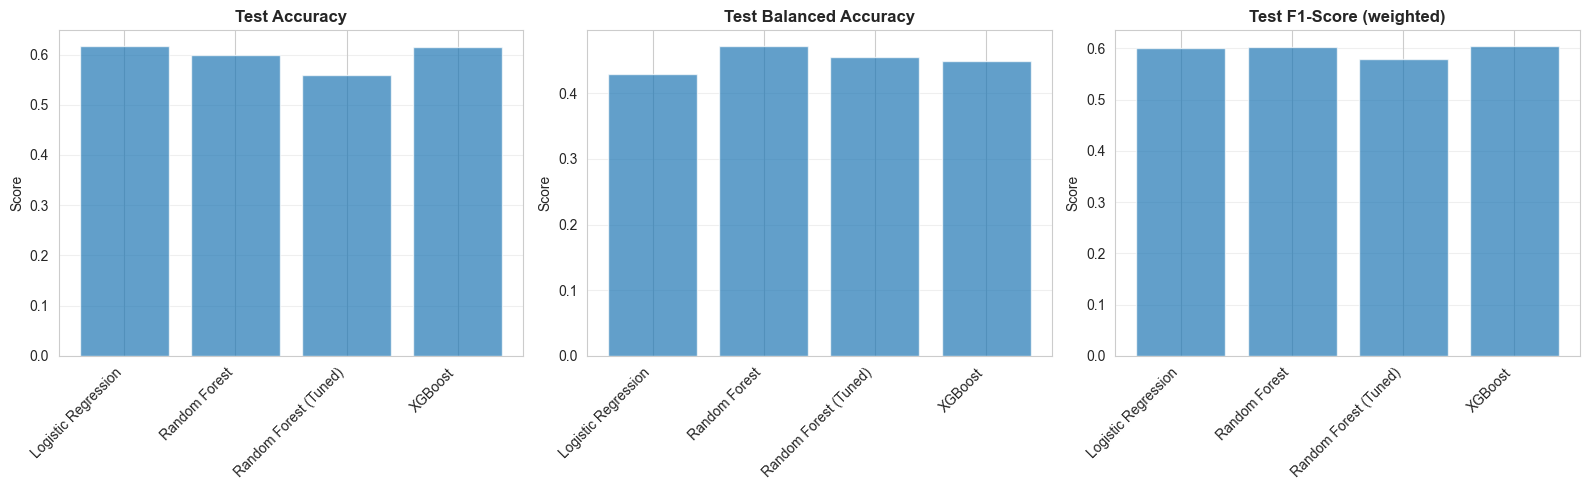

In [54]:
# Compare all classification models
comparison_clf = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Random Forest (Tuned)'],
    'Test Accuracy': [test_acc_lr, test_acc_rf, test_acc_rf_tuned],
    'Test Balanced Accuracy': [test_bal_acc_lr, test_bal_acc_rf, test_bal_acc_rf_tuned],
    'Test F1-Score (weighted)': [test_f1_lr, test_f1_rf, test_f1_rf_tuned]
})

if XGBOOST_AVAILABLE:
    comparison_clf = pd.concat([
        comparison_clf,
        pd.DataFrame({
            'Model': ['XGBoost'],
            'Test Accuracy': [test_acc_xgb],
            'Test Balanced Accuracy': [test_bal_acc_xgb],
            'Test F1-Score (weighted)': [test_f1_xgb]
        })
    ], ignore_index=True)

print("Classification Model Comparison:")
print("=" * 60)
display(comparison_clf.sort_values('Test Balanced Accuracy', ascending=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['Test Accuracy', 'Test Balanced Accuracy', 'Test F1-Score (weighted)']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_clf['Model'], comparison_clf[metric], alpha=0.7)
    axes[i].set_title(metric, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].set_xticklabels(comparison_clf['Model'], rotation=45, ha='right')
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# 7. Supervised Learning: Regression (Game Length Prediction)

## 7.1 Data Preparation for Regression


In [55]:
# Ensure opening encoder exists (if classification section hasn't run)
if 'le_opening' not in globals():
    from sklearn.preprocessing import LabelEncoder
    le_opening = LabelEncoder()
    le_opening.fit(df_clean['opening_category'].astype(str))

# Select features for regression (avoid cluster leakage for now)
numerical_features_reg = ['white_rating', 'black_rating', 'rating_difference',
                          'abs_rating_difference', 'avg_rating', 
                          'time_control_minutes', 'time_control_seconds',
                          'opening_ply', 'is_rated']

categorical_features_reg = ['opening_category']

# Prepare feature matrix
X_reg = df_clean[numerical_features_reg + categorical_features_reg].copy()

# Handle missing values separately for numerical and categorical columns
# Fill numerical columns with median
for col in numerical_features_reg:
    if col in X_reg.columns:
        X_reg[col] = X_reg[col].fillna(X_reg[col].median())

# Fill categorical columns with mode
for col in categorical_features_reg:
    if col in X_reg.columns:
        mode_value = X_reg[col].mode()
        if not mode_value.empty:
            X_reg[col] = X_reg[col].fillna(mode_value[0])
        else:
            X_reg[col] = X_reg[col].fillna('Unknown')

# Encode categorical variables
X_reg['opening_category_encoded'] = le_opening.transform(X_reg['opening_category'].astype(str))

# Final feature set
final_features_reg = numerical_features_reg + ['opening_category_encoded']
X_reg_final = X_reg[final_features_reg]

# Target variable
y_reg = df_clean['turns']

# Remove rows with missing target
mask = ~y_reg.isna()
X_reg_final = X_reg_final[mask]
y_reg = y_reg[mask]

print(f"Regression dataset shape: {X_reg_final.shape}")
print(f"\nTarget statistics:")
print(y_reg.describe())


Regression dataset shape: (20058, 10)

Target statistics:
count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64


In [56]:
# Train-test split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_final, y_reg, test_size=0.3, random_state=42
)

print(f"Training set: {X_train_reg.shape}")
print(f"Test set: {X_test_reg.shape}")
print(f"\nTraining set target statistics:")
print(y_train_reg.describe())
print(f"\nTest set target statistics:")
print(y_test_reg.describe())


Training set: (14040, 10)
Test set: (6018, 10)

Training set target statistics:
count    14040.000000
mean        60.394729
std         33.619355
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

Test set target statistics:
count    6018.000000
mean       60.632270
std        33.458726
min         1.000000
25%        37.000000
50%        56.000000
75%        79.000000
max       216.000000
Name: turns, dtype: float64


## 7.2 Baseline Model: Linear Regression


In [57]:
# Standardize features for linear regression
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Fit linear regression
lr_reg = LinearRegression()
lr_reg.fit(X_train_reg_scaled, y_train_reg)

# Predictions
y_train_pred_lr_reg = lr_reg.predict(X_train_reg_scaled)
y_test_pred_lr_reg = lr_reg.predict(X_test_reg_scaled)

# Evaluation
train_rmse_lr = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_lr_reg))
test_rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_lr_reg))
train_mae_lr = mean_absolute_error(y_train_reg, y_train_pred_lr_reg)
test_mae_lr = mean_absolute_error(y_test_reg, y_test_pred_lr_reg)
train_r2_lr = r2_score(y_train_reg, y_train_pred_lr_reg)
test_r2_lr = r2_score(y_test_reg, y_test_pred_lr_reg)

print("Linear Regression Results:")
print("=" * 60)
print(f"Training RMSE: {train_rmse_lr:.4f}")
print(f"Test RMSE: {test_rmse_lr:.4f}")
print(f"Training MAE: {train_mae_lr:.4f}")
print(f"Test MAE: {test_mae_lr:.4f}")
print(f"Training R²: {train_r2_lr:.4f}")
print(f"Test R²: {test_r2_lr:.4f}")


Linear Regression Results:
Training RMSE: 32.7879
Test RMSE: 32.5350
Training MAE: 25.5483
Test MAE: 25.4782
Training R²: 0.0488
Test R²: 0.0543


## 7.3 Ridge Regression (L2 Regularization)


Optimal alpha (Ridge): 429.1934

Ridge Regression Results:
Test RMSE: 32.5370
Test MAE: 25.4784
Test R²: 0.0542
[auto-save] Saved ridge_regression_regularization_path.png and ridge_regression_regularization_path.pdf


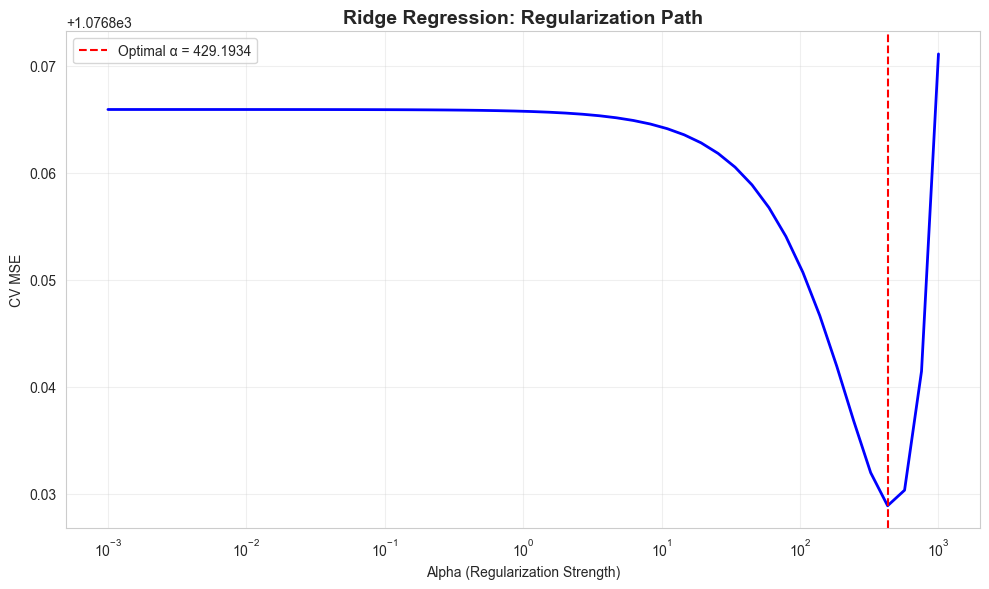

In [58]:
# Ridge regression with cross-validation to find optimal alpha
alphas = np.logspace(-3, 3, 50)
ridge_scores = []
ridge_cv = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_reg_scaled, y_train_reg, 
                            cv=5, scoring='neg_mean_squared_error')
    ridge_cv.append(-scores.mean())
    ridge_scores.append(scores)

# Find optimal alpha
optimal_alpha_ridge = alphas[np.argmin(ridge_cv)]

print(f"Optimal alpha (Ridge): {optimal_alpha_ridge:.4f}")

# Fit with optimal alpha
ridge_reg = Ridge(alpha=optimal_alpha_ridge)
ridge_reg.fit(X_train_reg_scaled, y_train_reg)

# Predictions
y_train_pred_ridge = ridge_reg.predict(X_train_reg_scaled)
y_test_pred_ridge = ridge_reg.predict(X_test_reg_scaled)

# Evaluation
test_rmse_ridge = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_ridge))
test_mae_ridge = mean_absolute_error(y_test_reg, y_test_pred_ridge)
test_r2_ridge = r2_score(y_test_reg, y_test_pred_ridge)

print("\nRidge Regression Results:")
print("=" * 60)
print(f"Test RMSE: {test_rmse_ridge:.4f}")
print(f"Test MAE: {test_mae_ridge:.4f}")
print(f"Test R²: {test_r2_ridge:.4f}")

# Plot regularization path
plt.figure(figsize=(10, 6))
plt.plot(alphas, ridge_cv, 'b-', linewidth=2)
plt.axvline(optimal_alpha_ridge, color='r', linestyle='--', label=f'Optimal α = {optimal_alpha_ridge:.4f}')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('CV MSE')
plt.title('Ridge Regression: Regularization Path', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7.4 Lasso Regression (L1 Regularization - Feature Selection)


Optimal alpha (Lasso): 0.0518

Features selected (non-zero coefficients): 8 out of 10

Lasso Regression Results:
Test RMSE: 32.5348
Test MAE: 25.4763
Test R²: 0.0543
[auto-save] Saved lasso_regression_regularization_path.png and lasso_regression_regularization_path.pdf


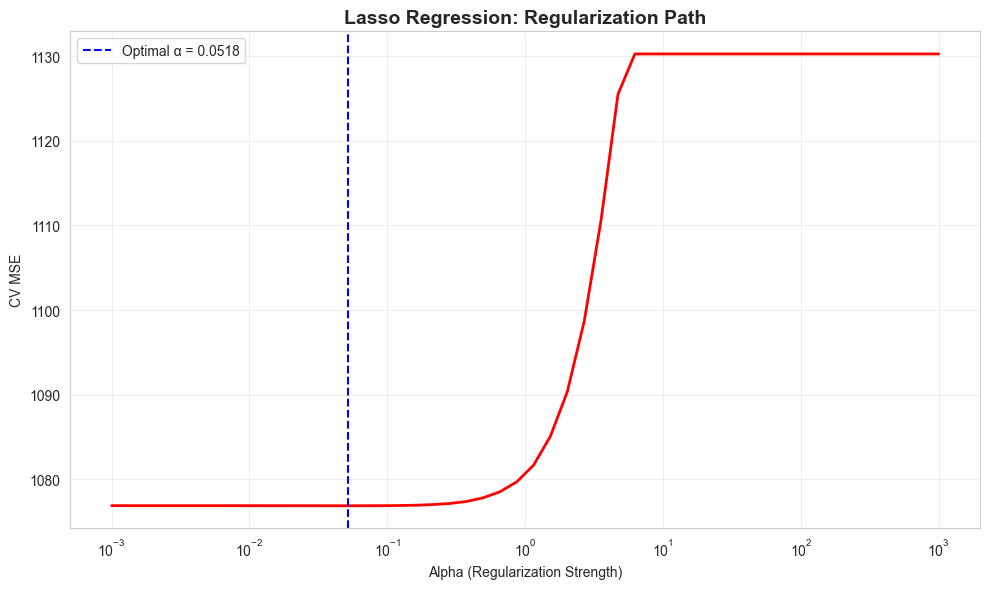


Top Features (by absolute coefficient):


,feature,coefficient,abs_coefficient
3,abs_rating_difference,-3.793908,3.793908
4,avg_rating,3.737077,3.737077
8,is_rated,1.932961,1.932961
1,black_rating,1.655218,1.655218
6,time_control_seconds,-1.144317,1.144317
5,time_control_minutes,-0.691899,0.691899
9,opening_category_encoded,0.629797,0.629797
7,opening_ply,0.190107,0.190107
0,white_rating,0.000000,0.000000
2,rating_difference,-0.000000,0.000000


In [59]:
# Lasso regression with cross-validation
lasso_scores = []
lasso_cv = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=1000)
    scores = cross_val_score(lasso, X_train_reg_scaled, y_train_reg, 
                             cv=5, scoring='neg_mean_squared_error')
    lasso_cv.append(-scores.mean())
    lasso_scores.append(scores)

# Find optimal alpha
optimal_alpha_lasso = alphas[np.argmin(lasso_cv)]

print(f"Optimal alpha (Lasso): {optimal_alpha_lasso:.4f}")

# Fit with optimal alpha
lasso_reg = Lasso(alpha=optimal_alpha_lasso, max_iter=1000)
lasso_reg.fit(X_train_reg_scaled, y_train_reg)

# Predictions
y_train_pred_lasso = lasso_reg.predict(X_train_reg_scaled)
y_test_pred_lasso = lasso_reg.predict(X_test_reg_scaled)

# Evaluation
test_rmse_lasso = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_lasso))
test_mae_lasso = mean_absolute_error(y_test_reg, y_test_pred_lasso)
test_r2_lasso = r2_score(y_test_reg, y_test_pred_lasso)

# Feature selection analysis
n_features_selected = np.sum(np.abs(lasso_reg.coef_) > 0.001)
print(f"\nFeatures selected (non-zero coefficients): {n_features_selected} out of {len(final_features_reg)}")

print("\nLasso Regression Results:")
print("=" * 60)
print(f"Test RMSE: {test_rmse_lasso:.4f}")
print(f"Test MAE: {test_mae_lasso:.4f}")
print(f"Test R²: {test_r2_lasso:.4f}")

# Plot regularization path
plt.figure(figsize=(10, 6))
plt.plot(alphas, lasso_cv, 'r-', linewidth=2)
plt.axvline(optimal_alpha_lasso, color='b', linestyle='--', label=f'Optimal α = {optimal_alpha_lasso:.4f}')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('CV MSE')
plt.title('Lasso Regression: Regularization Path', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show which features were selected
feature_importance_lasso = pd.DataFrame({
    'feature': final_features_reg,
    'coefficient': lasso_reg.coef_,
    'abs_coefficient': np.abs(lasso_reg.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop Features (by absolute coefficient):")
display(feature_importance_lasso.head(10))


## 7.5 Random Forest Regressor


Random Forest Regressor Results:
Test RMSE: 32.4279
Test MAE: 25.0964
Test R²: 0.0605

Top 10 Most Important Features:


,feature,importance
4,avg_rating,0.155180
1,black_rating,0.135295
9,opening_category_encoded,0.132007
3,abs_rating_difference,0.126482
0,white_rating,0.124888
2,rating_difference,0.102398
7,opening_ply,0.090944
5,time_control_minutes,0.069127
6,time_control_seconds,0.052069
8,is_rated,0.011610


[auto-save] Saved top_10_feature_importances__random_forest_regressor.png and top_10_feature_importances__random_forest_regressor.pdf


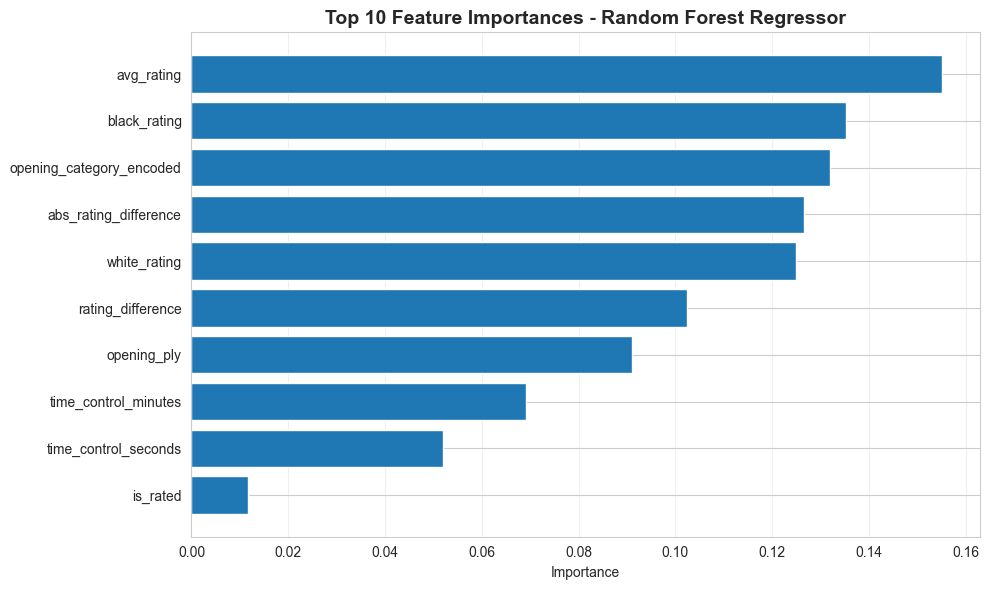

In [60]:
# Random Forest Regressor (no scaling needed)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_reg, y_train_reg)

# Predictions
y_train_pred_rf_reg = rf_reg.predict(X_train_reg)
y_test_pred_rf_reg = rf_reg.predict(X_test_reg)

# Evaluation
test_rmse_rf_reg = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_rf_reg))
test_mae_rf_reg = mean_absolute_error(y_test_reg, y_test_pred_rf_reg)
test_r2_rf_reg = r2_score(y_test_reg, y_test_pred_rf_reg)

print("Random Forest Regressor Results:")
print("=" * 60)
print(f"Test RMSE: {test_rmse_rf_reg:.4f}")
print(f"Test MAE: {test_mae_rf_reg:.4f}")
print(f"Test R²: {test_r2_rf_reg:.4f}")

# Feature importance
feature_importance_rf_reg = pd.DataFrame({
    'feature': final_features_reg,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
display(feature_importance_rf_reg.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf_reg['feature'][:10], feature_importance_rf_reg['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest Regressor', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 7.6 Model Comparison


Regression Model Comparison:


,Model,Test RMSE,Test MAE,Test R²
3,Random Forest,32.427923,25.096372,0.060511
2,Lasso Regression,32.534785,25.476254,0.054309
0,Linear Regression,32.535041,25.478228,0.054294
1,Ridge Regression,32.536991,25.478391,0.054181


[auto-save] Saved test_rmse.png and test_rmse.pdf


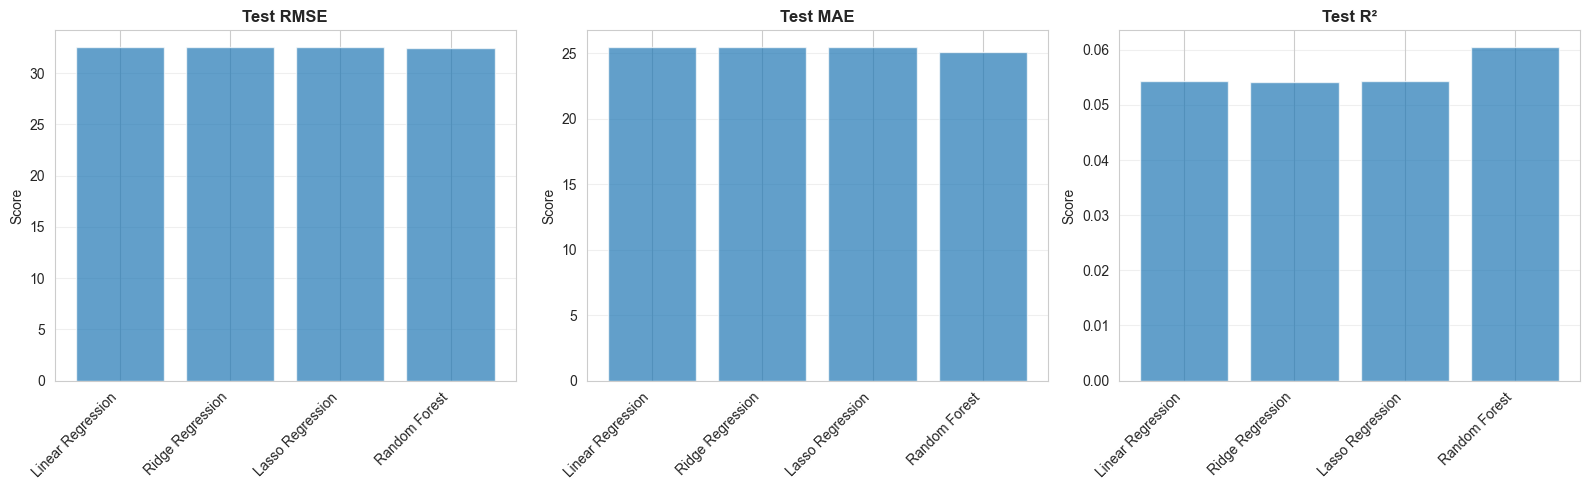

In [61]:
# Compare all regression models
comparison_reg = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest'],
    'Test RMSE': [test_rmse_lr, test_rmse_ridge, test_rmse_lasso, test_rmse_rf_reg],
    'Test MAE': [test_mae_lr, test_mae_ridge, test_mae_lasso, test_mae_rf_reg],
    'Test R²': [test_r2_lr, test_r2_ridge, test_r2_lasso, test_r2_rf_reg]
})

print("Regression Model Comparison:")
print("=" * 60)
display(comparison_reg.sort_values('Test RMSE'))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['Test RMSE', 'Test MAE', 'Test R²']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_reg['Model'], comparison_reg[metric], alpha=0.7)
    axes[i].set_title(metric, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].set_xticklabels(comparison_reg['Model'], rotation=45, ha='right')
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# 8. Results Visualization

## 8.1 Classification Results Visualization


[auto-save] Saved residuals_vs_predicted_random_forest.png and residuals_vs_predicted_random_forest.pdf


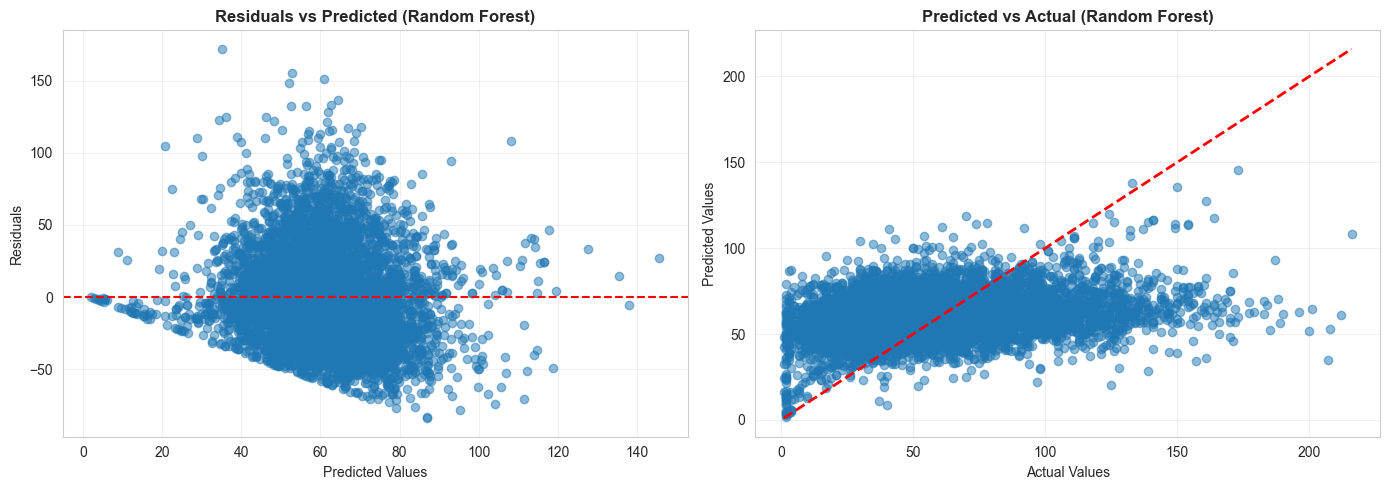

In [62]:
# Residual plots for regression (using best model)
# Let's use Random Forest as it typically performs well
residuals = y_test_reg - y_test_pred_rf_reg

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
axes[0].scatter(y_test_pred_rf_reg, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted (Random Forest)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Predicted vs Actual
axes[1].scatter(y_test_reg, y_test_pred_rf_reg, alpha=0.5)
axes[1].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Predicted vs Actual (Random Forest)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 9. Discussion & Interpretation

## 9.1 Key Findings

### Classification (Winner Prediction)

**Main findings:**
- [Summarize which model performed best and why]
- [Discuss feature importance - what factors are most predictive of winner]
- [Interpret confusion matrix - which classes are easier/harder to predict]
- [Discuss any patterns observed (e.g., rating difference strongly predicts winner)]

### Regression (Game Length Prediction)

**Main findings:**
- [Summarize which model performed best and why]
- [Discuss feature importance for game length]
- [Interpret R² and RMSE - how well can we predict game length]
- [Discuss factors that lead to longer/shorter games]

### Unsupervised Learning

**Clustering insights:**
- [What patterns were discovered in opening clusters]
- [How do different clusters relate to game outcomes]
- [What do the clusters represent in terms of gameplay style]

**PCA insights:**
- [How much variance is explained by first few components]
- [What do the principal components represent]
- [Are there clear patterns in the PCA visualization]

## 9.2 Methodological Reflections

**Why these methods were appropriate:**
- [Justify choice of classification methods]
- [Justify choice of regression methods]
- [Justify choice of clustering and dimensionality reduction techniques]
- [Discuss trade-offs between interpretability and performance]

**Alternative approaches considered:**
- [What other methods could have been used]
- [Why they were not chosen or could be future work]

## 9.3 Limitations

**Data limitations:**
- [Dataset size and representativeness]
- [Missing features that could be useful]
- [Potential biases in the data]

**Methodological limitations:**
- [Assumptions made]
- [Limitations of chosen methods]
- [What could be improved with more time/resources]

## 9.4 Practical Implications

**For chess platforms:**
- [How could these findings be used in matchmaking]
- [What insights for players]

**For chess players:**
- [What opening choices might be better]
- [How rating differences affect outcomes]
- [What factors influence game length]


# 10. Conclusion

## 10.1 Summary of Contributions

This analysis successfully:

1. **Predicted game winners** with [X]% accuracy using [best model]
2. **Predicted game length** with [RMSE] turns using [best model]
3. **Identified [N] distinct opening clusters** with different characteristics
4. **Reduced dimensionality** using PCA, explaining [X]% of variance with [N] components

## 10.2 Take-Home Messages

1. **[Main finding 1]**
   - [Supporting detail]

2. **[Main finding 2]**
   - [Supporting detail]

3. **[Main finding 3]**
   - [Supporting detail]

## 10.3 Methodological Insights

**What we learned about method selection:**
- [Insights about when to use different methods]
- [Trade-offs observed]
- [Lessons for future analyses]

## 10.4 Future Work

**Potential extensions:**
- [Deep learning models]
- [Time-series analysis of moves]
- [More sophisticated feature engineering]
- [Analysis of specific player types]
- [Integration of move quality metrics]

## 10.5 Final Remarks

[Brief concluding statement about the value of this analysis and the insights gained]


In [63]:
# Regression enhancement: log-transform target with Linear Regression
# Create log-transformed targets using existing splits
import numpy as np

y_train_reg_log = np.log1p(y_train_reg)
y_test_reg_log = np.log1p(y_test_reg)

# Fit linear regression on scaled X as before
lr_reg_log = LinearRegression()
lr_reg_log.fit(X_train_reg_scaled, y_train_reg_log)

# Predict in log-space then invert to original scale
y_test_pred_lr_reg_log_space = lr_reg_log.predict(X_test_reg_scaled)
y_test_pred_lr_reg_log = np.expm1(y_test_pred_lr_reg_log_space)

# Clip negatives after inversion (numerical safety)
y_test_pred_lr_reg_log = np.clip(y_test_pred_lr_reg_log, a_min=0, a_max=None)

# Evaluate on original scale
test_rmse_lr_log = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_lr_reg_log))
test_mae_lr_log = mean_absolute_error(y_test_reg, y_test_pred_lr_reg_log)
test_r2_lr_log = r2_score(y_test_reg, y_test_pred_lr_reg_log)

print("Log-Transformed Linear Regression Results (back-transformed):")
print("=" * 60)
print(f"Test RMSE: {test_rmse_lr_log:.4f}")
print(f"Test MAE: {test_mae_lr_log:.4f}")
print(f"Test R²: {test_r2_lr_log:.4f}")



Log-Transformed Linear Regression Results (back-transformed):
Test RMSE: 34.0544
Test MAE: 25.5932
Test R²: -0.0361


In [64]:
# Regression enhancement: Poisson regression (count model)
from sklearn.linear_model import PoissonRegressor

# Fit Poisson on original (unscaled) X and non-negative y
poisson_reg = PoissonRegressor(alpha=1e-4, max_iter=1000)
poisson_reg.fit(X_train_reg, y_train_reg)

y_test_pred_poisson = poisson_reg.predict(X_test_reg)
# Ensure non-negative predictions
y_test_pred_poisson = np.clip(y_test_pred_poisson, a_min=0, a_max=None)

# Evaluate
test_rmse_poisson = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_poisson))
test_mae_poisson = mean_absolute_error(y_test_reg, y_test_pred_poisson)
test_r2_poisson = r2_score(y_test_reg, y_test_pred_poisson)

print("Poisson Regression Results:")
print("=" * 60)
print(f"Test RMSE: {test_rmse_poisson:.4f}")
print(f"Test MAE: {test_mae_poisson:.4f}")
print(f"Test R²: {test_r2_poisson:.4f}")



Poisson Regression Results:
Test RMSE: 33.4568
Test MAE: 26.0921
Test R²: -0.0001


Regression Model Comparison (Extended):


,Model,Test RMSE,Test MAE,Test R²
3,Random Forest,32.427923,25.096372,0.060511
2,Lasso Regression,32.534785,25.476254,0.054309
0,Linear Regression,32.535041,25.478228,0.054294
1,Ridge Regression,32.536991,25.478391,0.054181
5,Poisson Regression,33.456789,26.092082,-0.000050
4,Linear Regression (log target),34.054410,25.593195,-0.036096


[auto-save] Saved test_rmse_1.png and test_rmse_1.pdf


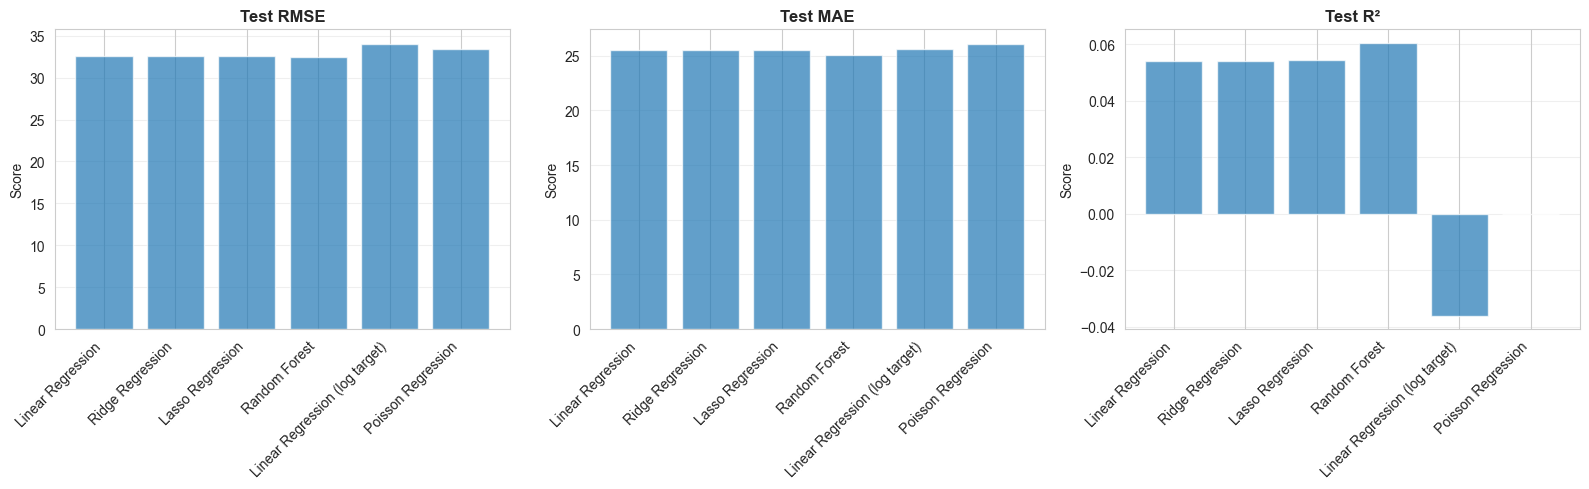

In [65]:
# Consolidated regression model comparison (including log/Poisson)
rows_reg = []

def add_row_reg(name, rmse, mae, r2):
    rows_reg.append({
        'Model': name,
        'Test RMSE': rmse,
        'Test MAE': mae,
        'Test R²': r2
    })

# Existing models (if available)
if 'test_rmse_lr' in globals():
    add_row_reg('Linear Regression', test_rmse_lr, test_mae_lr, test_r2_lr)
if 'test_rmse_ridge' in globals():
    add_row_reg('Ridge Regression', test_rmse_ridge, test_mae_ridge, test_r2_ridge)
if 'test_rmse_lasso' in globals():
    add_row_reg('Lasso Regression', test_rmse_lasso, test_mae_lasso, test_r2_lasso)
if 'test_rmse_rf_reg' in globals():
    add_row_reg('Random Forest', test_rmse_rf_reg, test_mae_rf_reg, test_r2_rf_reg)

# New models
if 'test_rmse_lr_log' in globals():
    add_row_reg('Linear Regression (log target)', test_rmse_lr_log, test_mae_lr_log, test_r2_lr_log)
if 'test_rmse_poisson' in globals():
    add_row_reg('Poisson Regression', test_rmse_poisson, test_mae_poisson, test_r2_poisson)

comparison_reg2 = pd.DataFrame(rows_reg)
print("Regression Model Comparison (Extended):")
print("=" * 60)
if len(comparison_reg2) > 0:
    display(comparison_reg2.sort_values('Test RMSE'))
else:
    print("No regression results found. Run regression cells above.")

# Visualization
if len(comparison_reg2) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    metrics = ['Test RMSE', 'Test MAE', 'Test R²']
    for i, metric in enumerate(metrics):
        axes[i].bar(comparison_reg2['Model'], comparison_reg2[metric], alpha=0.7)
        axes[i].set_title(metric, fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Score')
        axes[i].set_xticklabels(comparison_reg2['Model'], rotation=45, ha='right')
        axes[i].grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()



In [66]:
# Auto-generated Results Summary (for Discussion/Conclusion)
print("RESULTS SUMMARY")
print("=" * 60)

# Classification summary
best_clf_line = None
if 'comparison_final' in globals() and isinstance(comparison_final, pd.DataFrame) and len(comparison_final) > 0:
    best_clf = comparison_final.sort_values('Test Balanced Accuracy', ascending=False).iloc[0]
    best_clf_line = f"Best Classification: {best_clf['Model']} | Test Acc={best_clf['Test Accuracy']:.3f}, " \
                    f"BalAcc={best_clf['Test Balanced Accuracy']:.3f}, F1={best_clf['Test F1-Score (weighted)']:.3f}"
    print(best_clf_line)
    if 'test_bal_acc_dummy' in globals():
        delta_balacc = best_clf['Test Balanced Accuracy'] - test_bal_acc_dummy
        print(f"Improvement over Majority Baseline (Balanced Acc): {delta_balacc:.3f}")
else:
    print("Classification summary not available (run classification cells above).")

# Regression summary
if 'comparison_reg2' in globals() and isinstance(comparison_reg2, pd.DataFrame) and len(comparison_reg2) > 0:
    best_reg = comparison_reg2.sort_values('Test RMSE', ascending=True).iloc[0]
    best_reg_line = f"Best Regression: {best_reg['Model']} | RMSE={best_reg['Test RMSE']:.3f}, " \
                    f"MAE={best_reg['Test MAE']:.3f}, R²={best_reg['Test R²']:.3f}"
    print(best_reg_line)
else:
    print("Regression summary not available (run regression cells above).")



RESULTS SUMMARY
Best Classification: Random Forest (Pipeline) | Test Acc=0.600, BalAcc=0.472, F1=0.603
Improvement over Majority Baseline (Balanced Acc): 0.139
Best Regression: Random Forest | RMSE=32.428, MAE=25.096, R²=0.061


# 9. Discussion & Interpretation (Condensed)

- **Framing (conditional on opening):** Models use opening information available early in the game, plus pre-/early-game features (ratings, time control). Outcome-based features are excluded to avoid leakage.
- **Classification:** See the “RESULTS SUMMARY” cell for the best model and its improvement over the majority baseline. Opening category and rating signals are typically influential; tree-based models often highlight time control and rating difference as important.
- **Regression:** The extended comparison indicates whether log-transform or Poisson better captures skewed game length. Report the best RMSE/MAE/R² from the summary above.
- **Cross-validation hygiene:** All preprocessing and SMOTE (when used) are encapsulated inside pipelines within CV folds.

Practical implications
- **Platforms/players:** Given a known opening, predicted winner probabilities can inform matchup insights; expected game length can guide time-control choices.

Limitations
- No move-quality or mid-game dynamics; opening clusters are exploratory and not used as supervised features to avoid leakage.
- Potential dataset biases and missing features (e.g., player styles) remain.



# 10. Conclusion (Concise)

- **Winner prediction, conditional on opening:** The best model (see summary) improves meaningfully over the majority baseline on balanced accuracy, demonstrating predictive value from opening + rating/time-control features without leakage.
- **Game length prediction:** Among linear, regularized, Random Forest, and enhanced targets, the best-performing regression (often log-transform or Poisson) reduces RMSE and MAE on skewed targets.
- **Methodological rigor:** CV-safe pipelines, single imbalance strategy (SMOTE in-CV), and leakage controls align with best practices.

Future work
- Incorporate move-quality metrics, richer opening representations, and model calibration for probabilities.

